# Bogota Accessibility: Impact of the TransMiCable Gondola

### Brian Hill, Logan Ritter

The goal of this notebook will be to calculate preliminary accessibility estimates for Bogota using the simplified data on employment by Logan Ritter, and the GTFS file by Jarvis Yuan.  

The assumption is that before running this notebook the otp system as outlined in Bogota_OTP_Setup, including the appropriate GTFS, OSM, and Graph objects, as well as Jython, Pandas, Numpy, OSMNX.

### Overview
* [Establish Run Specifications](#run_spec)
* [Make Hexagons](#make_hexagons)
* [Distribute Employment](#distribute_employment)
* [OTP: Aquire Travel Times](#otp_travel_times)
* [Calculate Acessibility](#calculate_acessibility)
* [Data Visualizations](#data_vis)
* [Conclusion](#conclusion)


In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shutil
import glob
import time
import threading
import os
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import seaborn as sns
import shapely 
from shapely.geometry import Polygon
import mapclassify 
import pysal
import contextily as ctx
# Suppresss warnings 
import warnings
warnings.filterwarnings('ignore')

/Users/BrianHill/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:
# Set path to jython file 
# e.g. /Users/BrianHill/jython2.7.2/bin/jython
jython_path = '/Users/BrianHill/jython2.7.2/bin/jython'

# Set path to otp folder
# Ensure ends in a '/'
# e.g. /Users/BrianHill/otp/
otp_path = '/Users/BrianHill/otp/'

# Change notebook directory to otp_path
os.chdir(otp_path)

## Establish Run Specifications <a class="anchor" id="run_spec"></a>
The goal is to enable easy customization of input parameters, as well as the ability to store each run's results in a separate folder.

In [16]:
# Location to find city-specific data (e.g. jobs, administrative boundaries)
city_data = r'bogota_data/'

# Location to store run-specific data
run_folder_name = r'ba_5000m'
# We now make this directory
!mkdir {run_folder_name}

# Prefix to add to files from this run 
run_prefix = 'hex5000_'

# Together
run_path = run_folder_name + '/' + run_prefix
run_path

mkdir: ba_5000m: File exists


'ba_5000m/hex5000_'

In [7]:
# Hexagon size 
hexagon_diameter = 5000

# Set departure time for travel time calculations
# Format 'year, month, day, hour, minute, second'  (e.g. '2019, 4, 4, 6, 00, 00')
departure_time = r'2019, 4, 4, 6, 00, 00'

In [33]:
%%bash

cd graphs/bogota_no_gondola
# Router configuration details 
cat > router-config.json
{
  "boardTimes": {
    "BUS": 300
  },
  "routingDefaults": {
    "waitReluctance": 1,
    "waitAtBeginningFactor": 1,
    "walkReluctance": 1,
    "stairsReluctance": 1
  }
}


In [34]:
%%bash
# Copy router configuration to gondola router
cp graphs/bogota_no_gondola/router-config.json graphs/bogota_gondola/router-config.json


## Make Hexagons <a class="anchor" id="make_hexagons"></a>

In this step we cover the city with hexagons of the preset size.

In [10]:

# Get the Bogota city boundaires 
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
#bogota_boundary.plot()

# Import ability to draw distances from geodesic (precise)
from geopy.distance import geodesic
#geodesic(origin, dest).km*1000 returns length in meters 

# How large is the city?
xmin, ymin, xmax, ymax = bogota_boundary.total_bounds
# geodesic((latitude,longitude), (latitude, longitude))
dist_long = geodesic((ymin,xmin), (ymin,xmax)).km*1000
print("Longitudinal distance:", dist_long)
dist_lat = geodesic((ymin,xmin), (ymax,xmin)).km*1000
print("Latitudinal distance:", dist_lat)

# Diameter of hexagons 
d = hexagon_diameter

# Horizontal width of hexagon
w = np.sin(np.deg2rad(60))*d

# Approximate size of hexagon grid 
n_cols = int(dist_long/w) +1
print("Approx. number of columns: ", n_cols)
n_rows = int(dist_lat/(3/4 * d)) + 10
print("Approx. number of rows:", n_rows)

# Overlay with equally spaced hexagons

from matplotlib.patches import RegularPolygon

# ax = bogota_boundary.boundary.plot(edgecolor='black',figsize=(20,60))
w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon
array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        # ax.add_patch(hexes)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#plt.show()

# Extract hexagons inside of the boundary 

hex_grid = gpd.GeoDataFrame({'geometry':array_of_hexes},crs={'init':'epsg:4326'})
bogota_hex = gpd.overlay(hex_grid,bogota_boundary)
bogota_hex = gpd.GeoDataFrame(bogota_hex,geometry='geometry')
#bogota_hex.boundary.plot()

# Strip off unnecesary fields 
bogota_hex.reset_index(inplace=True)
bogota_hex.rename(columns={'index':'HEXID'},inplace=True)
bogota_hex = bogota_hex[['HEXID','geometry']]


Longitudinal distance: 23668.826877335207
Latitudinal distance: 40029.88097027054
Approx. number of columns:  6
Approx. number of rows: 20


## Distribute Employment <a class="anchor" id="distribute_employment"></a>

Using the jobs data from the 2019 Bogota household travel survey, we calculate the number of trips ending in each TAZ, and then, use tobler to distribute the jobs into each hexagon.  The jobs are distributed proportional to the area of the TAZ in the hexagon.  

In [12]:
# Load the survey data file and calculate number of work destinations in each TAZ
viajes = pd.read_csv(city_data + ("viajes.csv"), sep=';')
ZAT = gpd.read_file((city_data + "ZONAS/ZAT.shp"), sep=';')
viajes_clean = viajes[["id_hogar", "id_persona", "id_viaje", "p17_Id_motivo_viaje", "zat_origen", "zat_destino", "f_exp"]]
#counting the number of trips (either work related or all trips) in each TAZ
#origin is a boolean about whether we want to look at the origin or destination of the trips
#mintrips is used to filter out TAZ's that have a low number of trips to better zoom into the data
def location_counts(origin, only_jobs, min_trips, no_table=False):
    if origin:
        zat_column = "zat_origen"
    else:
        zat_column = "zat_destino"
    if only_jobs:
        viajes_new = viajes[viajes["p17_Id_motivo_viaje"] == 1]
    else:
        viajes_new = viajes
    counts = viajes_new.groupby(zat_column).sum()
    counts.reset_index(level = 0, inplace = True)
    counts["counts"] = counts["f_exp"]
    counts = counts[[zat_column, "counts"]]
    counts = pd.merge(counts, ZAT[["Area", "ZAT", "geometry"]], left_on = zat_column, right_on = "ZAT")
    counts = gpd.GeoDataFrame(counts, geometry=counts["geometry"])
    counts = counts[[zat_column, "counts", "geometry"]]
    counts = counts[counts["counts"] > min_trips]
    if no_table:
        return
    return counts
work_destination_counts = location_counts(False, True, 0)
work_destination_counts

zat_destino       counts  \
0             1.0   308.737618   
1             2.0   107.002656   
2             3.0   311.561784   
3             4.0   700.972891   
4             7.0  1622.454159   
...           ...          ...   
1013       1903.0  2650.408680   
1014       1904.0    92.772562   
1015       1905.0  4437.804867   
1016       1906.0   587.320839   
1017       1907.0   981.612664   

                                               geometry  
0     POLYGON Z ((-74.06383 4.77235 0.00000, -74.063...  
1     POLYGON Z ((-74.05306 4.82550 0.00000, -74.053...  
2     POLYGON Z ((-74.03007 4.82343 0.00000, -74.029...  
3     POLYGON Z ((-74.04066 4.78609 0.00000, -74.040...  
4     POLYGON Z ((-74.04154 4.77941 0.00000, -74.040...  
...                                                 ...  
1013  POLYGON Z ((-73.95672 4.94255 0.00000, -73.955...  
1014  POLYGON Z ((-73.86543 5.00181 0.00000, -73.847...  
1015  POLYGON Z ((-73.94001 4.93084 0.00000, -73.940...  
1016  POLYGON Z ((-73.98746 5.04507 0.00000, -73.986...  
1017  POLYGON Z ((-73.98386 5.04487 0.00000, -73.976...  

[1018 rows x 3 columns]

In [14]:
import tobler

# Tobler jobs 
work_destination_counts.crs = {'init':'epsg:4686'}
ZAT_with_jobs = work_destination_counts
ZAT_with_jobs = ZAT_with_jobs[["zat_destino", "geometry"]]
bogota_hex_jobs = bogota_hex
bogota_hex_jobs.crs = {'init':"epsg:4686"}
#bogota_hex_jobs = bogota_hex_jobs.to_crs("epsg:4686") # correct crs
bogota_hex_jobs["job_count"] = 0.0
distribution = tobler.area_weighted.area_tables(ZAT_with_jobs, bogota_hex_jobs)
mapping = distribution[0] @ distribution[1]
# Weighting the 
for i in mapping:
    total = sum(i)
    if total == 0.0:
        continue
    for j in range(len(i)):
        i[j] = i[j] / total
for i in range(len(mapping)):
    jobs = work_destination_counts.iloc[i, 1]
    dist = mapping[i]
    for j in range(len(dist)):
        fraction = dist[j]
        distributed_jobs = jobs * fraction
        bogota_hex_jobs["job_count"][j] += distributed_jobs
bogota_hex_jobs["jobs_count"] = bogota_hex_jobs["job_count"]
bogota_hex_jobs = bogota_hex_jobs[["HEXID", "geometry", "jobs_count"]]
bogota_hex_jobs.to_file((run_path + 'bogota_hex_jobs.shp'))
bogota_hex_jobs

HEXID                                           geometry     jobs_count
0       0  POLYGON ((-74.06502 4.82207, -74.07879 4.81412...     303.151780
1       1  POLYGON ((-74.02802 4.82333, -74.02802 4.82291...   12094.873001
2       2  MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4...    2660.098229
3       3  POLYGON ((-74.02802 4.82291, -74.02635 4.82194...    5162.137434
4       4  POLYGON ((-74.09911 4.76138, -74.09911 4.76134...   10044.188480
5       5  MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4...    5198.575758
6       6  POLYGON ((-74.04579 4.79213, -74.02802 4.78187...   31184.229087
7       7  POLYGON ((-74.12207 4.75408, -74.11688 4.75108...   21752.499466
8       8  POLYGON ((-74.09911 4.76134, -74.08134 4.75108...   57534.440839
9       9  POLYGON ((-74.06356 4.76134, -74.04579 4.75108...   49048.632794
10     10  POLYGON ((-74.02802 4.76134, -74.02128 4.75745...   52818.628324
11     11  POLYGON ((-74.17020 4.70465, -74.17020 4.70126...      49.978677
12     12  POLYGON ((-74.14622 4.72698, -74.13465 4.72030...   27573.742572
13     13  POLYGON ((-74.11688 4.73056, -74.09911 4.72030...   47699.711155
14     14  POLYGON ((-74.08134 4.73056, -74.06356 4.72030...   64359.213135
15     15  POLYGON ((-74.04579 4.73056, -74.02802 4.72030...  115780.039322
16     16  POLYGON ((-74.16927 4.69925, -74.15243 4.68952...   28056.722814
17     17  POLYGON ((-74.13465 4.69978, -74.11688 4.68952...   81448.693040
18     18  POLYGON ((-74.09911 4.69978, -74.08134 4.68952...  101878.671903
19     19  POLYGON ((-74.06356 4.69978, -74.04579 4.68952...  234725.768498
20     20  MULTIPOLYGON (((-74.01267 4.66760, -74.01879 4...   80313.401082
21     21  MULTIPOLYGON (((-74.20574 4.64138, -74.20574 4...     147.651716
22     22  POLYGON ((-74.17020 4.65653, -74.17020 4.63822...   12661.511022
23     23  POLYGON ((-74.15243 4.66900, -74.13465 4.65874...   59622.970832
24     24  POLYGON ((-74.11688 4.66900, -74.09911 4.65874...  130257.509886
25     25  POLYGON ((-74.08134 4.66900, -74.06356 4.65874...  135154.195010
26     26  POLYGON ((-74.04579 4.66900, -74.04250 4.66710...  114813.554501
27     27  POLYGON ((-74.20574 4.63822, -74.18797 4.62795...   28654.232029
28     28  POLYGON ((-74.17020 4.63822, -74.15243 4.62795...   58469.740307
29     29  POLYGON ((-74.13465 4.63822, -74.11688 4.62795...   80752.601554
30     30  POLYGON ((-74.09911 4.63822, -74.08134 4.62795...  150959.013487
31     31  POLYGON ((-74.06356 4.63822, -74.05552 4.63357...  194337.395488
32     32  POLYGON ((-74.18797 4.60743, -74.17020 4.59717...   20654.939838
33     33  POLYGON ((-74.15243 4.60743, -74.13465 4.59717...   55513.733587
34     34  POLYGON ((-74.11688 4.60743, -74.09911 4.59717...   85352.259303
35     35  POLYGON ((-74.08134 4.60743, -74.06473 4.59785...  153587.213539
36     36  POLYGON ((-74.06356 4.58631, -74.06356 4.58982...      24.728223
37     37  POLYGON ((-74.17020 4.57665, -74.15243 4.56639...    8497.524797
38     38  POLYGON ((-74.13465 4.57665, -74.11688 4.56639...   28715.273741
39     39  POLYGON ((-74.09911 4.57665, -74.08134 4.56639...   31306.955850
40     40  MULTIPOLYGON (((-74.08134 4.55931, -74.08134 4...    2502.598800
41     41  MULTIPOLYGON (((-74.15243 4.54587, -74.13618 4...    2889.669675
42     42  MULTIPOLYGON (((-74.10037 4.53634, -74.09911 4...   16163.120125
43     43  MULTIPOLYGON (((-74.08134 4.54587, -74.07815 4...    4326.694469
44     44  MULTIPOLYGON (((-74.12733 4.51086, -74.11688 4...    1423.901975
45     45  MULTIPOLYGON (((-74.09432 4.51232, -74.08846 4...   13479.405219
46     46  MULTIPOLYGON (((-74.08134 4.49792, -74.08134 4...     368.898316
47     47  POLYGON ((-74.08312 4.47282, -74.08308 4.47295...     390.101076

## OTP: Aquire Travel Times <a class="anchor" id="otp_travel_time"></a>

We will be running analysis on the overall accessibility with and without the gondola for all of bogota using the hexagons.  

Also here we consider changing the python script to make it more managable to do calculations on them, to calculate the accessibility mid-way through instead of at the end.  Also, the code has been properly threaded and currently saves multiple csvs instead of just one big one to avoid memory errors.

Further, for speed improvements the code has been parallized.


In [15]:
# Add in longitude and latitude of the centroid of each hexagon to prepare for Open Trip Planner Processing
bogota_hex_point_jobs = gpd.GeoDataFrame(bogota_hex_jobs)
bogota_hex_point_jobs['centroid'] = bogota_hex_point_jobs.centroid
bogota_hex_point_jobs.set_geometry('centroid', inplace=True)
bogota_hex_point_jobs['longitude'] = bogota_hex_point_jobs.geometry.x
bogota_hex_point_jobs['latitude'] = bogota_hex_point_jobs.geometry.y

# Save as simple csv to be accessed by processing script later
bogota_hex_point_jobs[['HEXID','longitude','latitude']].to_csv((run_path + 'bogota_hex_jobs.csv'))

bogota_hex_point_jobs

HEXID                                           geometry     jobs_count  \
0       0  POLYGON ((-74.06502 4.82207, -74.07879 4.81412...     303.151780   
1       1  POLYGON ((-74.02802 4.82333, -74.02802 4.82291...   12094.873001   
2       2  MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4...    2660.098229   
3       3  POLYGON ((-74.02802 4.82291, -74.02635 4.82194...    5162.137434   
4       4  POLYGON ((-74.09911 4.76138, -74.09911 4.76134...   10044.188480   
5       5  MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4...    5198.575758   
6       6  POLYGON ((-74.04579 4.79213, -74.02802 4.78187...   31184.229087   
7       7  POLYGON ((-74.12207 4.75408, -74.11688 4.75108...   21752.499466   
8       8  POLYGON ((-74.09911 4.76134, -74.08134 4.75108...   57534.440839   
9       9  POLYGON ((-74.06356 4.76134, -74.04579 4.75108...   49048.632794   
10     10  POLYGON ((-74.02802 4.76134, -74.02128 4.75745...   52818.628324   
11     11  POLYGON ((-74.17020 4.70465, -74.17020 4.70126...      49.978677   
12     12  POLYGON ((-74.14622 4.72698, -74.13465 4.72030...   27573.742572   
13     13  POLYGON ((-74.11688 4.73056, -74.09911 4.72030...   47699.711155   
14     14  POLYGON ((-74.08134 4.73056, -74.06356 4.72030...   64359.213135   
15     15  POLYGON ((-74.04579 4.73056, -74.02802 4.72030...  115780.039322   
16     16  POLYGON ((-74.16927 4.69925, -74.15243 4.68952...   28056.722814   
17     17  POLYGON ((-74.13465 4.69978, -74.11688 4.68952...   81448.693040   
18     18  POLYGON ((-74.09911 4.69978, -74.08134 4.68952...  101878.671903   
19     19  POLYGON ((-74.06356 4.69978, -74.04579 4.68952...  234725.768498   
20     20  MULTIPOLYGON (((-74.01267 4.66760, -74.01879 4...   80313.401082   
21     21  MULTIPOLYGON (((-74.20574 4.64138, -74.20574 4...     147.651716   
22     22  POLYGON ((-74.17020 4.65653, -74.17020 4.63822...   12661.511022   
23     23  POLYGON ((-74.15243 4.66900, -74.13465 4.65874...   59622.970832   
24     24  POLYGON ((-74.11688 4.66900, -74.09911 4.65874...  130257.509886   
25     25  POLYGON ((-74.08134 4.66900, -74.06356 4.65874...  135154.195010   
26     26  POLYGON ((-74.04579 4.66900, -74.04250 4.66710...  114813.554501   
27     27  POLYGON ((-74.20574 4.63822, -74.18797 4.62795...   28654.232029   
28     28  POLYGON ((-74.17020 4.63822, -74.15243 4.62795...   58469.740307   
29     29  POLYGON ((-74.13465 4.63822, -74.11688 4.62795...   80752.601554   
30     30  POLYGON ((-74.09911 4.63822, -74.08134 4.62795...  150959.013487   
31     31  POLYGON ((-74.06356 4.63822, -74.05552 4.63357...  194337.395488   
32     32  POLYGON ((-74.18797 4.60743, -74.17020 4.59717...   20654.939838   
33     33  POLYGON ((-74.15243 4.60743, -74.13465 4.59717...   55513.733587   
34     34  POLYGON ((-74.11688 4.60743, -74.09911 4.59717...   85352.259303   
35     35  POLYGON ((-74.08134 4.60743, -74.06473 4.59785...  153587.213539   
36     36  POLYGON ((-74.06356 4.58631, -74.06356 4.58982...      24.728223   
37     37  POLYGON ((-74.17020 4.57665, -74.15243 4.56639...    8497.524797   
38     38  POLYGON ((-74.13465 4.57665, -74.11688 4.56639...   28715.273741   
39     39  POLYGON ((-74.09911 4.57665, -74.08134 4.56639...   31306.955850   
40     40  MULTIPOLYGON (((-74.08134 4.55931, -74.08134 4...    2502.598800   
41     41  MULTIPOLYGON (((-74.15243 4.54587, -74.13618 4...    2889.669675   
42     42  MULTIPOLYGON (((-74.10037 4.53634, -74.09911 4...   16163.120125   
43     43  MULTIPOLYGON (((-74.08134 4.54587, -74.07815 4...    4326.694469   
44     44  MULTIPOLYGON (((-74.12733 4.51086, -74.11688 4...    1423.901975   
45     45  MULTIPOLYGON (((-74.09432 4.51232, -74.08846 4...   13479.405219   
46     46  MULTIPOLYGON (((-74.08134 4.49792, -74.08134 4...     368.898316   
47     47  POLYGON ((-74.08312 4.47282, -74.08308 4.47295...     390.101076   

                     centroid  longitude  latitude  
0   POINT (-74.07365 4.82034) -74.073652  4.820345  
1   POINT (-74.04469 4.822

#### Create Script

Here we use the %%bash command to use terminal to write the travel time calculating script.  Note that we have included the customizable run_path variable in two ways.  First, we passed it into the first line using 's- {run_path}' then refrencing it as ${1}.  Second, we used set to, somewhat less elegantly, 'replace to_be_filled_run_path' with our run_path variable. 

We also replace 'to_be_filled_departure_time' with our departure_time variable. 

In [35]:
%%bash -s {run_path}
cat > "${1}parallel_no_gondola.py"
import time
import threading
import shutil
import glob
# ENTIRE CITY IN HEXAGONS
router = 'bogota_no_gondola'
my_run_path = 'to_be_filled_run_path'
my_otp_path = 'to_be_filled_otp_path'
points_file = my_run_path + 'bogota_hex_jobs.csv'
dest_file = points_file
output_file = my_run_path + 'parallel_no_gondola.csv'
max_threads = 4
# SOURCE: RAFAEL PRERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint
# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', router])
# Start timing the code
start_time = time.time()
# Get the default router
router = otp.getRouter(router)
# Create a default request for a given departure time
req = otp.createRequest()
req.setDateTime(to_be_filled_departure_time)  # set departure time
req.setModes('WALK,BUS,RAIL,TRANSIT')         # define transport mode
req.setClampInitialWait(0)

points = otp.loadCSVPopulation(points_file, 'latitude', 'longitude')
dests = otp.loadCSVPopulation(dest_file, 'latitude', 'longitude')
def do_the_stuff(h,i, origin, req):
    # Create a CSV output
    matrixCsv = otp.createCSVOutput()
    #matrixCsv.setHeader([ 'year','depart_time', 'origin', 'destination', 'walk_distance', 'travel_time' ])
    #print("Processing origin: ", str(h)+"-"+str(0)," ", origin.getStringData('GEOID'), 'on ',threading.current_thread())
    req.setOrigin(origin)
    spt = router.plan(req)
    if spt is None: return
    # Evaluate the SPT for all points
    result = spt.eval(dests)
    # Add a new row of result in the CSV output
    for r in result:
       matrixCsv.addRow([ origin.getStringData('HEXID'), r.getIndividual().getStringData('HEXID'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])
    # Save the result
    csv_name = my_run_path + 'zarb_unique_' + 'no_gondola_origin' + str(origin.getStringData('HEXID')) + '.csv'
    matrixCsv.save(csv_name)
    print(csv_name)
    print("Time since start was %g seconds" % (time.time() - start_time))
# start looping over jobs
i = 1
origins = []
for origin in points:
    origins.append(origin)
while i < len(origins) + 1:
    if threading.active_count() < max_threads + 1:
        origin = origins[i - 1]
        thread = threading.Thread(target=do_the_stuff,args=(6,i, origin, req))
        thread.start()
        #thread.daemon = True        
        i += 1
    else:
        time.sleep(0.1)
# now wait for all daemon threads to end before letting
# the main thread die. Otherwise stuff will get cut off
# before it's finished
while threading.active_count() > 1:
    time.sleep(0.1)
print('ALL JOBS COMPLETED! Concatenating files')
#import csv files from folder
path = my_otp_path + my_run_path
allFiles = glob.glob(path + 'zarb_unique_' + 'no_gondola_origin*.csv')
allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
with open(output_file, 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if True:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")
print("Elapsed time was %g seconds" % (time.time() - start_time))



In [36]:
# Fill in to_be_filled_run_path with stored run_path variable 
!sed -i '' "s#to_be_filled_run_path#{run_path}#" {run_path}parallel_no_gondola.py
# Fill in departure time with stored departure_time variable
!sed -i '' "s#to_be_filled_departure_time#{departure_time}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_otp_path with otp path
!sed -i '' "s#to_be_filled_otp_path#{otp_path}#" {run_path}parallel_no_gondola.py


We also make the gondola script by replacing every instance of no_gondola with gondola, thus refrencing the gondola router instead of the no_gondola router, and saving file names appropriately.

In [37]:
%%bash -s {run_path}
sed 's/no_gondola/gondola/' ${1}parallel_no_gondola.py > ${1}parallel_gondola.py


### Run Travel Time Calculations

#### No Gondola

In [44]:
# Run the python script on the java OTP jar using jython
!{jython_path} -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar {run_path}parallel_no_gondola.py
!say done processing no gondola nodes


15:09:02.590 INFO (OTPServer.java:39) Wiring up and configuring server.
15:09:02.867 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_no_gondola]
15:09:02.867 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
15:09:02.876 INFO (GraphService.java:176) Registering new router 'bogota_no_gondola'
15:09:02.876 INFO (InputStreamGraphSource.java:181) Loading graph...
15:09:03.362 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
15:09:03.362 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
15:09:03.363 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
15:09:11.646 INFO (Graph.java:731) Main graph read. |V|=238654 |E|=1275454
hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
15:09:14.914 INFO (GraphIndex.java:127) Indexing graph...
15:09:16.8

In [45]:
%%bash -s {run_path}
# Remove all of the intermediary files
rm ${1}*zarb_unique*

#### Gondola

In [29]:
# Repeat for gondola scenario
!{jython_path} -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar {run_path}parallel_gondola.py
!say done processing gondola nodes


14:37:34.416 INFO (OTPServer.java:39) Wiring up and configuring server.
14:37:34.638 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_gondola]
14:37:34.639 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
14:37:34.647 INFO (GraphService.java:176) Registering new router 'bogota_gondola'
14:37:34.648 INFO (InputStreamGraphSource.java:181) Loading graph...
14:37:35.112 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
14:37:35.113 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
14:37:35.114 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
14:37:44.705 INFO (Graph.java:731) Main graph read. |V|=241656 |E|=1282226
hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
14:37:49.207 INFO (GraphIndex.java:127) Indexing graph...
14:37:51.356 INF

/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin30.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin31.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin32.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin33.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin34.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin35.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin36.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin37.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin38.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin39.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_gondola_origin4.csv has been imported.
/Users/Bria

In [30]:
%%bash -s {run_path}
# Remove all of the intermediary files
rm ${1}*zarb_unique*

## Calculate Accessibility  <a class="anchor" id="calculate_acessibility"></a>

Now we have created the hexagons, jobs and travel times data.  All of these datasets are saved locally in the run folder.  If the notebook has been run before, it is possible to restart from here and load in the data.  It is also possible to load in the data of another previous run to analyze. 

We will first specify which run we want to work with, and process to get acessibilities at various thresholds.


In [157]:
# INPUT FILES 
# Specify the folder and prefix to look for run results

# Set path to otp folder
# Ensure ends in a '/'
# e.g. /Users/BrianHill/otp/
otp_path = '/Users/BrianHill/otp/'  #<-------INPUT

# Change notebook directory to otp_path
os.chdir(otp_path)

# Location to find city-specific data (e.g. jobs, administrative boundaries)
# Ensure ends in '/', e.g. 'bogota_data/'
city_data = 'bogota_data/'         #<------INPUT

# Location to store run-specific data
run_folder_name = r'ba_5000m'      #<------INPUT

# Prefix to add to files from this run 
run_prefix = 'hex5000_'            #<------INPUT

# Together
run_path = run_folder_name + '/' + run_prefix


'ba_5000m/hex5000_'

In [ ]:
# This sets the specified values to the appropriate names
gondola_csv = run_path + 'parallel_no_gondola.csv'
no_gondola_csv = run_path + 'parallel_gondola.csv'
bogota_hex_jobs_shp = run_path + 'bogota_hex_jobs.shp'

In [133]:
bogota_hex_jobs = gpd.read_file(bogota_hex_jobs_shp)

# PROCESSING TO GET ACCESSIBILITIES
travel_time_no_gondola = pd.read_csv(no_gondola_csv, header=None)
#display(travel_time_no_gondola)
travel_time_no_gondola.columns = [ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ]
travel_time_no_gondola['travel_time_min'] = travel_time_no_gondola['travel_time']/60
travel_time_no_gondola.drop(columns=['walk_distance','boardings','travel_time'], inplace=True)

travel_time_gondola = pd.read_csv(gondola_csv, header=None)
#display(travel_time_gondola)
travel_time_gondola.columns = [ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ]
travel_time_gondola['travel_time_min'] = travel_time_gondola['travel_time']/60
travel_time_gondola.drop(columns=['walk_distance','boardings', 'travel_time'], inplace=True)
#travel_time_gondola

# Combine results 
travel_times_all = pd.merge(travel_time_no_gondola, travel_time_gondola, on = ['origin', 'destination'], suffixes=('_no_gondola','_gondola'))
#travel_times_all['change_time_min'] = travel_times_all['travel_time_min_no_gondola'] - travel_times_all['travel_time_min_gondola']

# Merge in destinations jobs data
geo_travel_times_all = pd.merge(travel_times_all, bogota_hex_jobs[['HEXID','jobs_count']], how= 'left', left_on='destination', right_on='HEXID')
geo_travel_times_all.rename(columns={'jobs_count':'jobs_count_destination'}, inplace=True)
geo_travel_times_all.drop(columns='HEXID', inplace=True)
#geo_travel_times_all


# Calculate accessibilities 
bogota_hex_access_no_gondola = bogota_hex_jobs[['HEXID', 'geometry']]
bogota_hex_access_gondola = bogota_hex_jobs[['HEXID','geometry']]

for cutoff in [0,10,20,30,40,50,60,70,80,90,100,110,120] :
    
    access_no_gondola = geo_travel_times_all[(geo_travel_times_all['travel_time_min_no_gondola'] < cutoff)].groupby('origin').agg(np.sum)[['jobs_count_destination']]
    access_no_gondola.rename(columns={'jobs_count_destination':cutoff}, inplace=True)
    bogota_hex_access_no_gondola = pd.merge(left=bogota_hex_access_no_gondola, right=access_no_gondola, left_on='HEXID', right_index=True, how='left')
    
    access_gondola = geo_travel_times_all[(geo_travel_times_all['travel_time_min_gondola'] < cutoff)].groupby('origin').agg(np.sum)[['jobs_count_destination']]
    access_gondola.rename(columns={'jobs_count_destination':cutoff}, inplace=True)
    bogota_hex_access_gondola = pd.merge(left=bogota_hex_access_gondola, right=access_gondola, left_on='HEXID', right_index=True, how='left')

# Fill na values 
bogota_hex_access_no_gondola.fillna(0, inplace=True)
bogota_hex_access_gondola.fillna(0, inplace=True)

display(bogota_hex_access_no_gondola.head(10))



HEXID                                           geometry    0  \
0      0  POLYGON ((-74.06502 4.82207, -74.07879 4.81412...  0.0   
1      1  POLYGON ((-74.02802 4.82333, -74.02802 4.82291...  0.0   
2      2  MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4...  0.0   
3      3  POLYGON ((-74.02802 4.82291, -74.02635 4.82194...  0.0   
4      4  POLYGON ((-74.09911 4.76138, -74.09911 4.76134...  0.0   
5      5  MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4...  0.0   
6      6  POLYGON ((-74.04579 4.79213, -74.02802 4.78187...  0.0   
7      7  POLYGON ((-74.12207 4.75408, -74.11688 4.75108...  0.0   
8      8  POLYGON ((-74.09911 4.76134, -74.08134 4.75108...  0.0   
9      9  POLYGON ((-74.06356 4.76134, -74.04579 4.75108...  0.0   

             10            20             30             40             50  \
0      0.000000      0.000000       0.000000       0.000000       0.000000   
1      0.000000      0.000000       0.000000       0.000000       0.000000   
2      0.000000      0.000000       0.000000       0.000000       0.000000   
3      0.000000      0.000000       0.000000       0.000000       0.000000   
4  10044.188480  10044.188480   10044.188480   72777.205077   94529.704543   
5   5198.575758   5198.575758   62733.016597  174648.810391  594677.510405   
6  31184.229087  31184.229087   31184.229087   31184.229087   31184.229087   
7  31184.229087  31184.229087   31184.229087   31184.229087   31184.229087   
8  57534.440839  57534.440839   62733.016597  158888.917678  875660.275480   
9  49048.632794  49048.632794  113407.845930  287209.433530  451786.225330   

             60            70            80            90           100  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  3.704528e+05  1.075162e+06  1.210316e+06  1.736249e+06  2.017824e+06   
5  1.108437e+06  1.372080e+06  1.837998e+06  2.049008e+06  2.206414e+06   
6  3.634791e+04  3.634791e+04  1.503144e+05  2.774066e+05  1.038945e+06   
7  3.634791e+04  3.634791e+04  1.503144e+05  2.774066e+05  1.038945e+06   
8  1.431703e+06  1.924976e+06  2.045909e+06  2.307564e+06  2.393554e+06   
9  1.018909e+06  1.432983e+06  2.049008e+06  2.049008e+06  2.313467e+06   

            110           120  
0  0.000000e+00  0.000000e+00  
1  0.000000e+00  0.000000e+00  
2  0.000000e+00  0.000000e+00  
3  0.000000e+00  0.000000e+00  
4  2.080340e+06  2.341376e+06  
5  2.390520e+06  2.415534e+06  
6  1.282891e+06  1.723809e+06  
7  1.282891e+06  1.723809e+06  
8  2.415534e+06  2.417308e+06  
9  2.382855e+06  2.401000e+06

## Data Visualization <a class="anchor" id="data_vis"></a>

We chose a few key visualizations to reveal how employment and acessibility varied across the city, as well as how it changed with the advent of the gondola.  The key plots are outlined below:

1. Employment Plot 

2. Bogota Accessibility Total Plot (no gondola case)

3. Bogota Acessibility Change Plot

4. Ciudad Bolivar Acessiblity Change Plot


### 1. Employment Plot 

(0.0, 1.0, 0.0, 1.0)

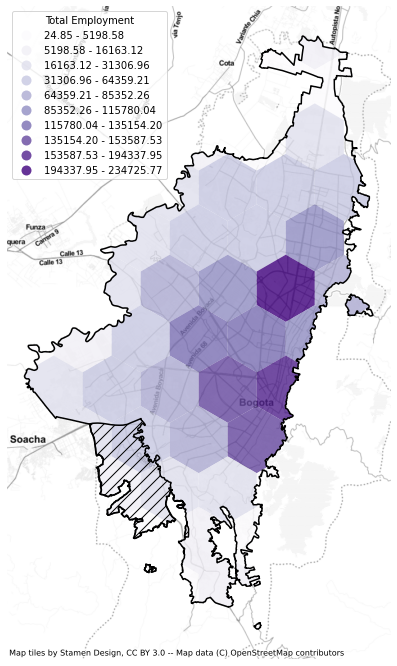

In [138]:
# 1 EMPLOYMENT PLOT 

# When using double square root, notice how it becomes clear how jobs are concentrated at some points and not others
bogota_hex_jobs_projected = bogota_hex_jobs
bogota_hex_jobs_projected['sqrt_jobs'] = np.sqrt(np.sqrt(bogota_hex_jobs_projected['jobs_count']))
bogota_hex_jobs_projected.crs = {'init':'epsg:4326'}
bogota_hex_jobs_projected = bogota_hex_jobs_projected.to_crs(epsg=3857)

# Figure Setup 
fig, ax = plt.subplots(1,1, figsize=(12,12))
#plt.title('Employment Distribution')
plt.axis('off')

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Plot Employment
bogota_hex_jobs_projected.plot(ax = ax, column = 'jobs_count', legend=True, legend_kwds={"loc":'upper left',"title":"Total Employment"}, cmap='Purples', alpha=0.8, scheme='naturalbreaks', k=10)

# Ciudad Bolivar Hatched
neighborhood_boundaries = gpd.read_file(city_data + 'bogota_neighborhood_boundaries.shp')
ciudad_bolivar_full_boundary = neighborhood_boundaries[neighborhood_boundaries['LocNombre'] == 'CIUDAD BOLIVAR']
ciudad_bolivar_full_boundary = ciudad_bolivar_full_boundary.to_crs(epsg=3857)
ciudad_bolivar_boundary = gpd.overlay(ciudad_bolivar_full_boundary, bogota_boundary, how='intersection')
ciudad_bolivar_boundary.plot(ax=ax, hatch="//", color='w', alpha=0)
ciudad_bolivar_boundary.boundary.plot(ax=ax, color='k')

# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot1_employment.png', dpi=400)


### 2. Bogota Acessibility Total Plot (no gondola data)

(-8263710.779758155, -8237596.124453148, 496213.3985239591, 540686.6920358697)

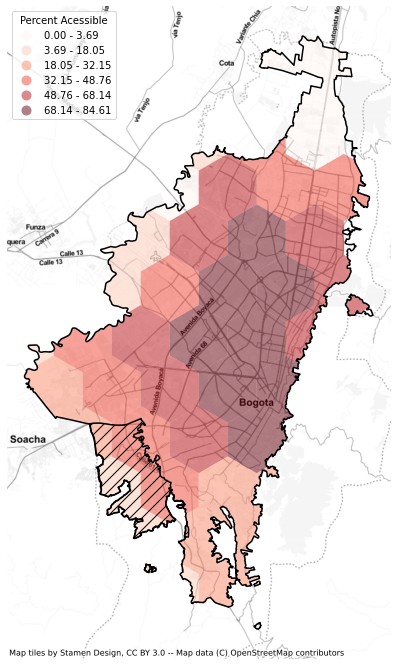

In [140]:
# 2. BOGOTA ACESSIBILITY PLOT

bogota_hex_access_no_gondola_projected = bogota_hex_access_no_gondola
bogota_hex_access_no_gondola_projected.crs = {'init':'epsg:4326'}
bogota_hex_access_no_gondola_projected = bogota_hex_access_no_gondola_projected.to_crs(epsg=3857)

# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_no_gondola_projected['60_percent'] = 100*bogota_hex_access_no_gondola_projected[60]/sum(bogota_hex_jobs['jobs_count'])
bogota_hex_access_no_gondola_projected.plot(ax = ax, column = '60_percent', legend=True, legend_kwds={"loc":'upper left',"title":"Percent Acessible"}, cmap='Reds', alpha=0.5, scheme='quantiles', k=6)
# plt.title('60 Minute Employment Acessibility in Bogota')
plt.axis('off')

# Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# Ciudad Bolivar Label
# ciudad_bolivar_y, ciudad_bolivar_x = 4.546088, -74.153357
# plt.text(ciudad_bolivar_x, ciudad_bolivar_y, 'Ciudad Bolivar', fontsize=10)
# plt.scatter(ciudad_bolivar_x, ciudad_bolivar_y, marker='*', s = 50)

# Ciudad Bolivar Hatched
neighborhood_boundaries = gpd.read_file(city_data + 'bogota_neighborhood_boundaries.shp')
ciudad_bolivar_full_boundary = neighborhood_boundaries[neighborhood_boundaries['LocNombre'] == 'CIUDAD BOLIVAR']
ciudad_bolivar_full_boundary = ciudad_bolivar_full_boundary.to_crs(epsg=3857)
ciudad_bolivar_boundary = gpd.overlay(ciudad_bolivar_full_boundary, bogota_boundary, how='intersection')
ciudad_bolivar_boundary.plot(ax=ax, hatch="//", color='w', alpha=0)
ciudad_bolivar_boundary.boundary.plot(ax=ax, color='k')

# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot2_bogota_acesss_total.png', dpi=400)



### 3. Bogota Acessibility Change

(-8263710.779758154, -8237596.124453148, 496213.3985239591, 540686.6920358697)

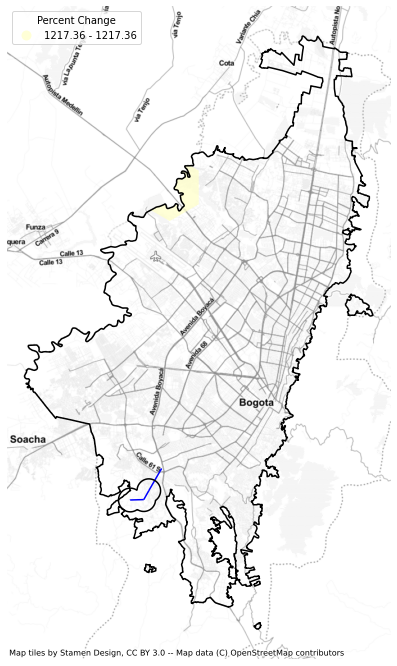

In [142]:
# 3. WHOLE CITY CHANGE PLOT 

# Calculate absolute and percent change
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns
for col in cols :
    # ABSOLUTE TOGGLE
    # bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    # PERCENT TOGGLE
    bogota_hex_access_change[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

    
# Drop all zero valued hexagons  
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Drop outlier hexagons
#bogota_hex_access_change = bogota_hex_access_change.drop(index=[243,15,4052], axis=0)

# Drop all hexagons outside ciudad bolivar
# xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
# bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]

# Change projection type
bogota_hex_access_change.crs = {'init':'epsg:4326'}
bogota_hex_access_change = bogota_hex_access_change.to_crs(epsg=3857)

# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_change.plot(ax = ax, column = 60, legend=True, legend_kwds={"loc":'upper left',"title":"Percent Change"}, cmap='YlOrRd', alpha=0.8, scheme='naturalbreaks', k=9)      
# plt.title('Percent Change in 60 minute Acessibility in Ciudad Bolivar')
plt.axis('off')

# Zoom into Ciudad Bolivar
# xmin, xmax, ymin, ymax = -8256500, -8252500, 506100, 509500
# ax.set_xlim(xmin,xmax)
# ax.set_ylim(ymin,ymax)

# Gondola new 
# gondola_stations = pd.read_csv('points_origins.csv')
# gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
# gondola_stations.crs = {'init':'epsg:4326'}
# gondola_stations = gondola_stations.to_crs(epsg=3857)
# gondola_stations.plot(ax=ax, color='r')

# Gondola Names
# for x, y, label in zip(gondola_stations.geometry.x, gondola_stations.geometry.y, gondola_stations['Description']):
#     ax.annotate(label, xy=(x, y), xytext=(0, -15), textcoords="offset points")

# Gondola from SHP file 
gondola_estaciones = gpd.read_file(city_data + 'Estaciones.shp')
gondola_estaciones.crs = {'init':'epsg:4326'}
gondola_estaciones = gondola_estaciones.to_crs(epsg=3857)
gondola_estaciones.plot(ax=ax, color='b')

gondola_line = gpd.read_file(city_data + 'tmc_line.shp')
gondola_line.crs = {'init':'epsg:4326'}
gondola_line = gondola_line.to_crs(epsg=3857)
gondola_line.plot(ax=ax, color='b')
    
# Plot 800 meter buffer around site 
gondola_area = gpd.read_file(city_data + 'cablesarea.geojson')
gondola_area = gondola_area[gondola_area['station_area'] == 'cb']
# gondola_area.crs = {'init':'epsg:4326'}
gondola_area = gondola_area.to_crs(epsg=3857)
gondola_area.boundary.plot(ax=ax, color='k')
    

# OLD Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')


# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot3_bogota_access_change.png', dpi=400)



### 4. Ciudad Bolivar Acessibility Change

(-8254083.037162622, -8250490.13853151, 525868.3053541264, 530018.8355276199)

(-8256500.0, -8252500.0)

(506100.0, 509500.0)

Text(0, -15, 'Mirador-Paraiso station')

Text(0, -15, 'Manitas station')

Text(0, -15, 'Juan Pablo II station')

Text(0, -15, 'Portal Tunal')

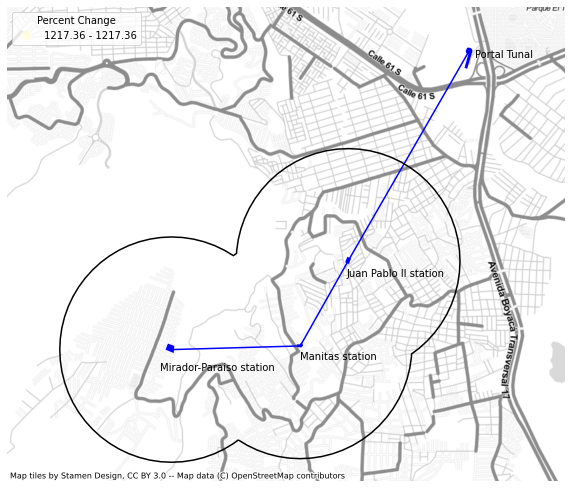

In [143]:
# CIUDAD BOLIVAR PLOT 

# Calculate absolute and percent change
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns
for col in cols :
    # ABSOLUTE TOGGLE
    # bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    # PERCENT TOGGLE
    bogota_hex_access_change[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

    
# Drop all zero valued hexagons  
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Drop outlier hexagons
# bogota_hex_access_change = bogota_hex_access_change.drop(index=[243,15,4052], axis=0)

# Drop all hexagons outside ciudad bolivar
# xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
# bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]

# Change projection type
bogota_hex_access_change.crs = {'init':'epsg:4326'}
bogota_hex_access_change = bogota_hex_access_change.to_crs(epsg=3857)


# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(10,10))

# Bogota Boundary
# place = {'city': 'Bogota',
#          'country':'Colombia'}
# bogota_boundary = ox.gdf_from_place(place)
# bogota_boundary.crs = {'init':'epsg:4326'}
# bogota_boundary = bogota_boundary.to_crs(epsg=3857)
# bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_change.plot(ax = ax, column = 60, legend=True, legend_kwds={"loc":'upper left','title':'Percent Change'}, cmap='YlOrRd', alpha=0.5, scheme='naturalbreaks', k=9)
# plt.title('Percent Change in 60 minute Acessibility in Ciudad Bolivar')
plt.axis('off')

# Zoom into Ciudad Bolivar
xmin, xmax, ymin, ymax = -8256500, -8252500, 506100, 509500
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

# Gondola Names
gondola_stations = pd.read_csv(city_data + 'gondola_stations.csv')
gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
gondola_stations.crs = {'init':'epsg:4326'}
gondola_stations = gondola_stations.to_crs(epsg=3857)
for x, y, label in zip(gondola_stations.geometry.x, gondola_stations.geometry.y, gondola_stations['Description']):
    ax.annotate(label, xy=(x, y), xytext=(0, -15), textcoords="offset points")
# gondola_stations.plot(ax=ax, color='r')
    
# Gondola from SHP file 
gondola_estaciones = gpd.read_file(city_data + 'Estaciones.shp')
gondola_estaciones.crs = {'init':'epsg:4326'}
gondola_estaciones = gondola_estaciones.to_crs(epsg=3857)
gondola_estaciones.plot(ax=ax, color='b')

gondola_line = gpd.read_file(city_data + 'tmc_line.shp')
gondola_line.crs = {'init':'epsg:4326'}
gondola_line = gondola_line.to_crs(epsg=3857)
gondola_line.plot(ax=ax, color='b')
    
# Plot 800 meter buffer around site 
gondola_area = gpd.read_file(city_data + 'cablesarea.geojson')
gondola_area = gondola_area[gondola_area['station_area'] == 'cb']
# gondola_area.crs = {'init':'epsg:4326'}
gondola_area = gondola_area.to_crs(epsg=3857)
gondola_area.boundary.plot(ax=ax, color='k')
    

# OLD Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')


# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plotr_ciudad_bolivar_access_change.png', dpi=400)



## Conclusion <a class="anchor" id="conclusion"></a>

Remarks on the plots and data analysis across different hexagon sizes can be found in our paper.

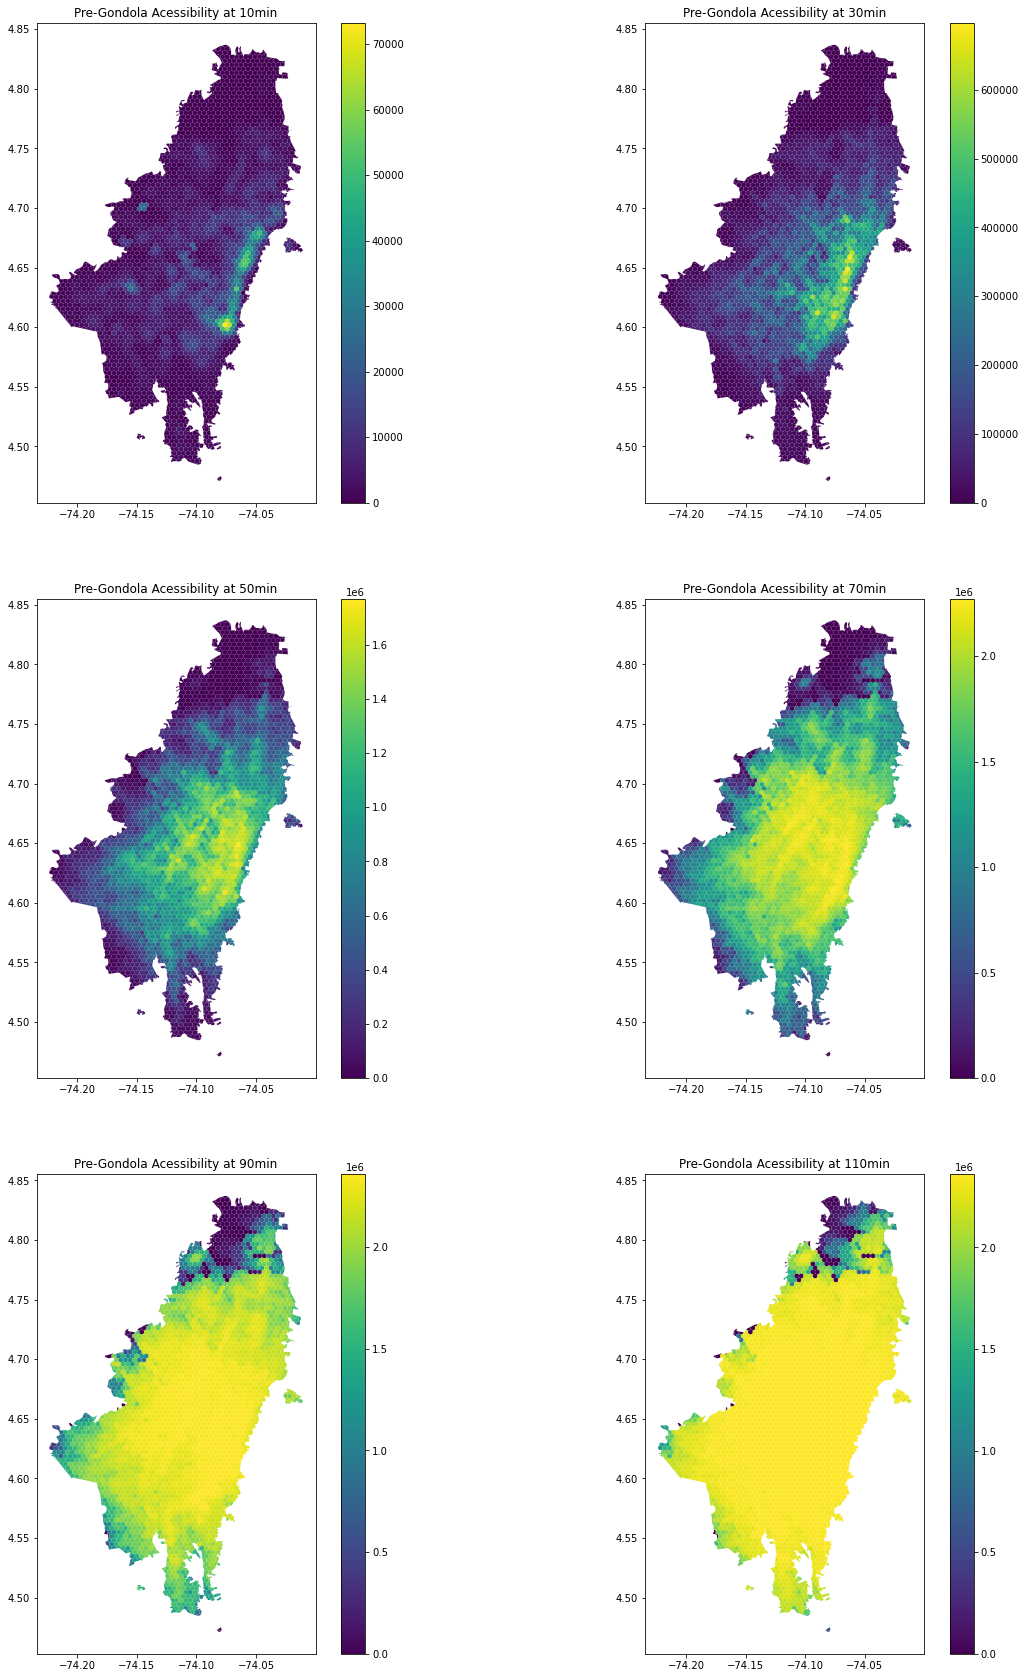

In [147]:
# Plot accessibility at 60 minute mark

times = [10, 30, 50, 70, 90, 110]

fix, axs = plt.subplots(3,2, figsize = (20,30))

for i in range(len(times)) :
    row_spot = math.floor(i/2)
    col_spot = i%2
    bogota_hex_access_no_gondola.plot(ax=axs[row_spot,col_spot], column = times[i], legend=True)
    title = 'Pre-Gondola Acessibility at ' + str(times[i]) + 'min'
    axs[row_spot,col_spot].set_title(title)



IndexError: index 5 is out of bounds for axis 0 with size 5

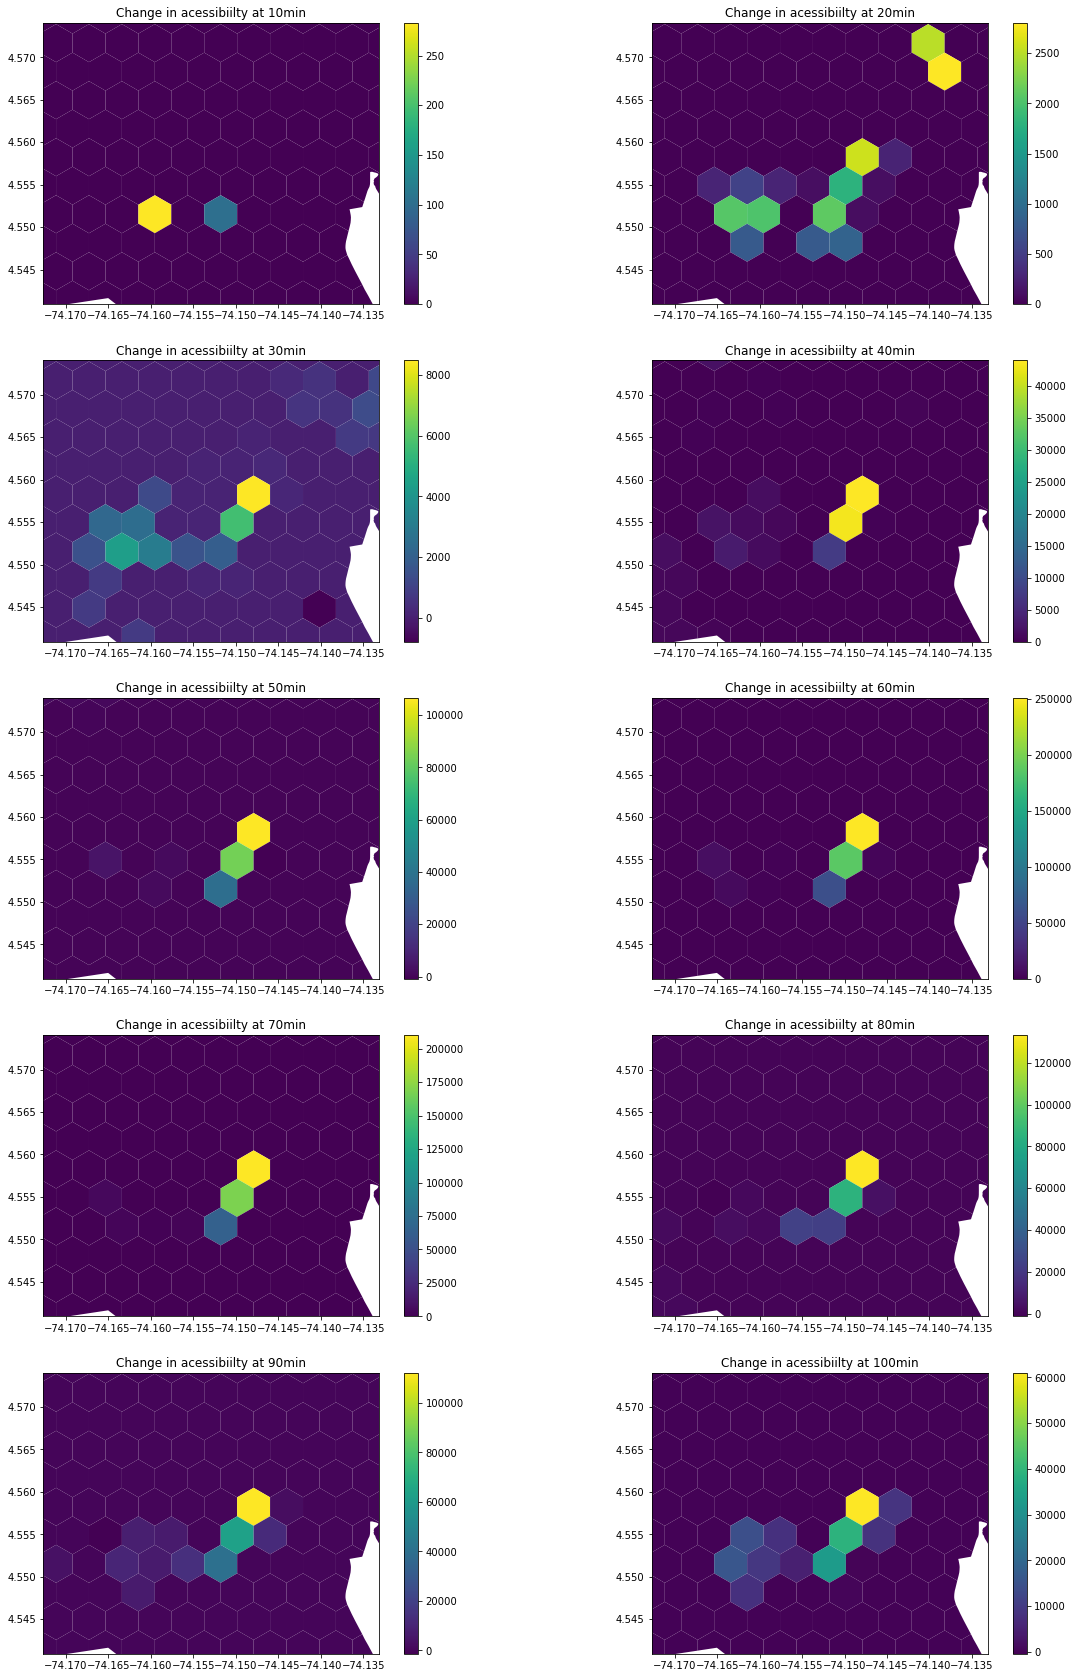

In [164]:
# Plot Change in Accessibility before/after gondola 
# display(bogota_hex_access_no_gondola)
# display(bogota_hex_access_gondola)

bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]

cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns

for col in cols :
    bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    
times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

fix, axs = plt.subplots(math.floor(i/2),2, figsize = (20,30))

for i in range(len(times)) :
    row_spot = math.floor(i/2)
    col_spot = i%2
    bogota_hex_access_change.plot(ax=axs[row_spot,col_spot], column = times[i], legend=True)
    title = 'Change in acessibiilty at ' + str(times[i]) + 'min'
    axs[row_spot,col_spot].set_title(title)
    # Ciudad bolivar Boundaries
    xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
    axs[row_spot,col_spot].set_xlim(xmin,xmax)
    axs[row_spot,col_spot].set_ylim(ymin,ymax)
    
    

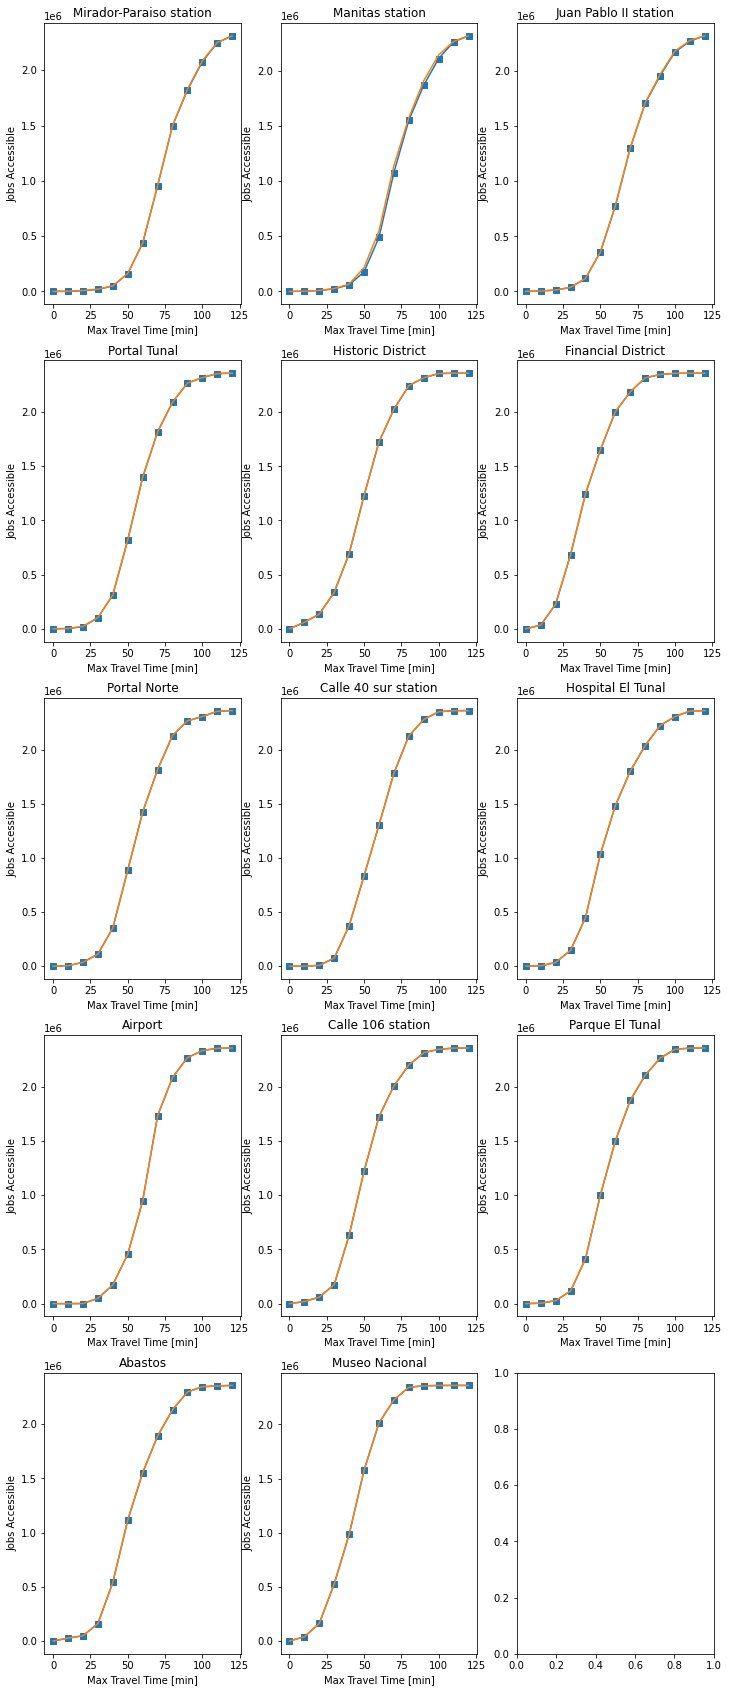

In [166]:
# Plot the graphs for a given points accessability 
# Inputs: 
    # Hexagons with accessitiblities
    # File with points desired to have accessibility calculated at

points = pd.read_csv('points_destinations.csv')

geo_points = gpd.GeoDataFrame(points, geometry=geopandas.points_from_xy(points['X'], points['Y']))

from shapely.ops import nearest_points

points_with_hexid = gpd.sjoin(geo_points, bogota_hex, how='left', op='within')


# hex_points = nearest_points(geo_points.unary_union, bogota_hex_centroid.unary_union)
# print(hex_points)

to_plot = points_with_hexid

columns = 3
rows = math.floor((len(to_plot)/columns))+1
fig, axs = plt.subplots(rows, columns, figsize=(12, 6*rows))
#fig.suptitle('Acessibility at various points (Orange:Gondola, Blue: No Gondola)')

for i in range(len(to_plot)) :  
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = 'no gondola')

    gon_vals = bogota_hex_access_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(gon_vals.index, gon_vals.values, label = 'gondola')
    
    axs[math.floor(i/columns), i%columns].set_title(to_plot['Description'][i])
    axs[math.floor(i/columns), i%columns].set_ylabel('Jobs Accessible')
    axs[math.floor(i/columns), i%columns].set_xlabel('Max Travel Time [min]')




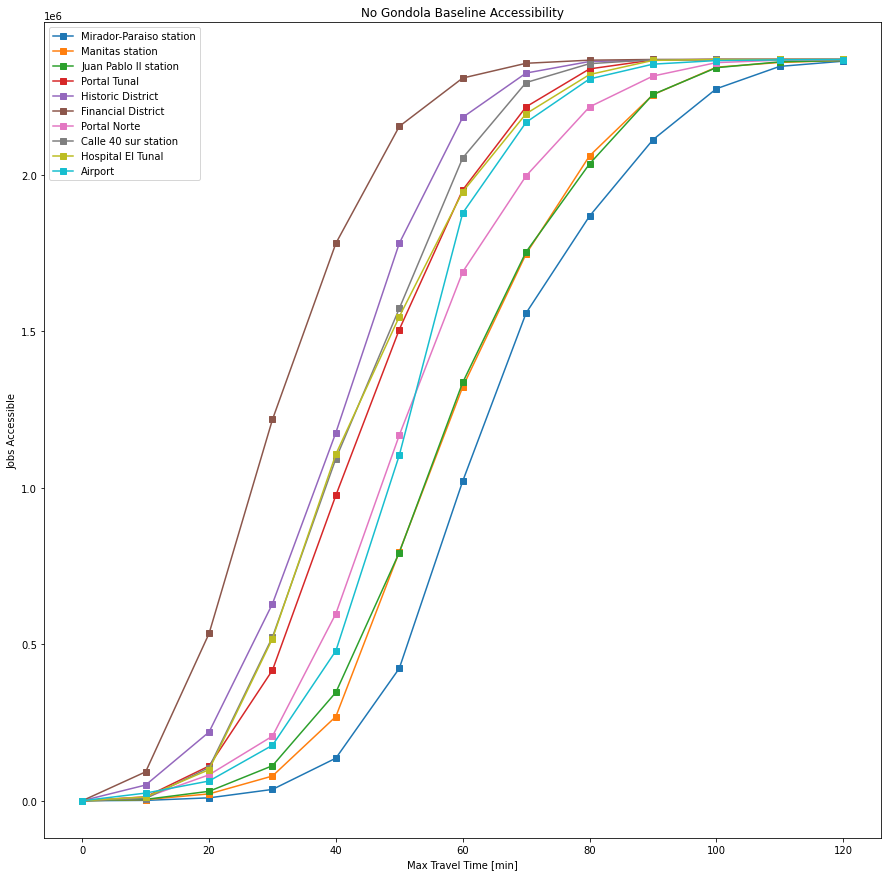

In [121]:
to_plot = points_with_hexid

fig, ax = plt.subplots(figsize=(15,15))
ax.set_ylabel('Jobs Accessible')
ax.set_xlabel('Max Travel Time [min]')
ax.set_title('No Gondola Baseline Accessibility')

to_plot = points_with_hexid.iloc[0:10]

for i in range(len(to_plot)):
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    ax.plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = to_plot['Description'][i])

ax.legend()



# +===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+

# Scratchwork



Text(186.08396683590956, 0.5, 'Latitude')

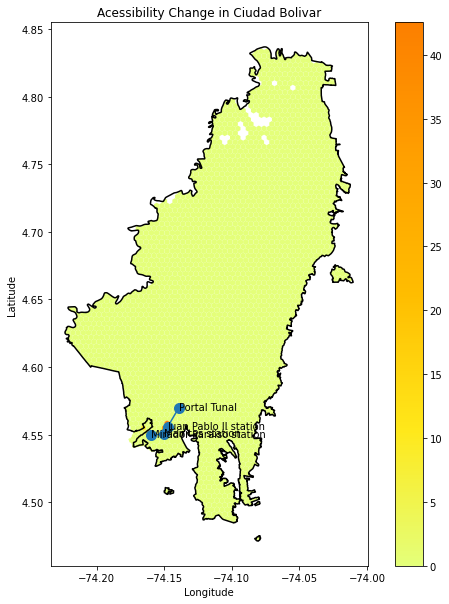

In [246]:
# Plot Ciudad bolivar specific Area 
# Plot hexagons showing change (with white/transparent being zero)
# Plot gondola stations, ideally with labels 
# Plot background terrain for context of hexagons 

bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change_percent = bogota_hex_access_no_gondola[['HEXID','geometry']]


cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns

for col in cols :
    bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    bogota_hex_access_change_percent[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

# Drop all zero valued hexagons to reflect 
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Ciudad bolivar Boundaries
xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]


fig, ax = plt.subplots(1,1, figsize = (10,10))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
#bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Street Network
# fig, ax = ox.plot_graph(ax=ax, G)

# Hexagons
# bogota_hex_access_change vs. bogota_hex_access_change_percent , can toggle
bogota_hex_access_change_percent.plot(ax=ax, column = 60, legend=True, cmap="Wistia")

ax.plot(points_origins['X'],points_origins['Y'])
# Gondola
for i in range(len(points_origins)) : 
    plt.text(points_origins['X'][i], points_origins['Y'][i]-.0015, points_origins['Description'][i], fontsize= 10)
plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=100)

plt.title('Acessibility Change in Ciudad Bolivar')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add basemap
#ctx.add_basemap(ax)



In [239]:
# Find geometries with most and least changed travel times!
geo_travel_times_all[geo_travel_times_all['travel_time_min_gondola'] != geo_travel_times_all['travel_time_min_no_gondola']]['origin'].value_counts()

3330    811
3289    557
3366    282
3368    107
3365     89
       ... 
2620      1
1938      1
2632      1
1862      1
1861      1
Name: origin, Length: 1405, dtype: int64

In [ ]:
fig, axs = plt.subplots(rows, columns, figsize=(12, 6*rows))
#fig.suptitle('Acessibility at various points (Orange:Gondola, Blue: No Gondola)')

for i in range(len(to_plot)) :  
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = 'no gondola')

    gon_vals = bogota_hex_access_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(gon_vals.index, gon_vals.values, label = 'gondola')
    
    axs[math.floor(i/columns), i%columns].set_title(to_plot['Description'][i])
    axs[math.floor(i/columns), i%columns].set_ylabel('Jobs Accessible')
    axs[math.floor(i/columns), i%columns].set_xlabel('Max Travel Time [min]')

### SCRATCHWORK

In [31]:
%%bash 
cat > travel_time_no_gondola_accessibility_all.py

# LOOK AT ALL POINTS

router = 'bogota_no_gondola'
points_file = 'job_count_by_block.csv'
dest_file = points_file
output_file = 'travel_time_no_gondola_accessibility_all.csv'


# SOURCE: RAFAEL PRERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint

# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', router])

# Start timing the code
import time
start_time = time.time()

# Get the default router
router = otp.getRouter(router)


# Create a default request for a given departure time
req = otp.createRequest()
req.setDateTime(2019, 4, 4, 9, 00, 00)  # set departure time 
req.setModes('WALK,BUS,RAIL,TRANSIT')             # define transport mode

# for more routing options, check: http://dev.opentripplanner.org/javadoc/0.19.0/org/opentripplanner/scripting/api/OtpsRoutingRequest.html


# Read Points of Destination - The file points.csv contains the columns GEOID, X and Y.
points = otp.loadCSVPopulation(points_file, 'latitude', 'longitude')
dests = otp.loadCSVPopulation(dest_file, 'latitude', 'longitude')


# Start Loop
for origin in points:
  print "Processing origin: ", origin
  req.setOrigin(origin)
  spt = router.plan(req)
  if spt is None: continue

  # Evaluate the SPT for all points
  result = spt.eval(dests)
  
  # Create a CSV output
  matrixCsv = otp.createCSVOutput()
  #matrixCsv.setHeader([ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ])

  # Add a new row of result in the CSV output
  for r in result:
    matrixCsv.addRow([ origin.getStringData('OBJECTID'), r.getIndividual().getStringData('OBJECTID'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])

  # Save the result
  csv_name = 'z_origin' + str(origin.getStringData('OBJECTID')) + '.csv'
  matrixCsv.save(csv_name)
  print(csv_name)
  print("Time since start was %g seconds" % (time.time() - start_time))


# Concatenate all of the csv files into one file 

import shutil
import glob


#import csv files from folder
path = r'/Users/BrianHill/otp'
allFiles = glob.glob(path + "/z_origin*.csv")
allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
with open(output_file, 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if True:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")


# Stop timing the code
print("Elapsed time was %g seconds" % (time.time() - start_time))

In [45]:
%%bash 
/Users/BrianHill/jython2.7.2/bin/jython -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar travel_time_no_gondola_accessibility_all.py


Process is terminated.


In [43]:
%%bash 
cat > test_make_csv.py

from org.opentripplanner.scripting.api import OtpsEntryPoint

# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', 'bogota_no_gondola'])
#

#matrixCsv.setHeader([ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ])

# Start Loop
for i in range(100):
  
  # Make a csv output file
  matrixCsv = otp.createCSVOutput()
  
  # Evaluate the SPT for all points
  result = range(100)

  # Add a new row of result in the CSV output
  for r in result:
    matrixCsv.addRow([ i, r,'dab', 3, 4 ])
    
  # Save the matrix as csv 
  csv_name = 'z_origin' + str(i) + '.csv'
  matrixCsv.save(csv_name)

# Concatenate all of the csv files into one file 

import shutil
import glob


#import csv files from folder
path = r'/Users/BrianHill/otp'
allFiles = glob.glob(path + "/z_origin*.csv")
allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
with open('someoutputfile.csv', 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if True:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")


# Stop timing the code
#print("Elapsed time was %g seconds" % (time.time() - start_time))

In [57]:
# Concatenates files in the directory, could be added to the python script too

import shutil
import glob


#import csv files from folder
path = r'/Users/BrianHill/otp'
allFiles = glob.glob(path + "/z_origin*.csv")
allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
with open('travel_time_no_gondola_accessibility_all.csv', 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if True:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")

/Users/BrianHill/otp/z_origin1.csv has been imported.
/Users/BrianHill/otp/z_origin10.csv has been imported.
/Users/BrianHill/otp/z_origin100.csv has been imported.
/Users/BrianHill/otp/z_origin1000.csv has been imported.
/Users/BrianHill/otp/z_origin1001.csv has been imported.
/Users/BrianHill/otp/z_origin1002.csv has been imported.
/Users/BrianHill/otp/z_origin1003.csv has been imported.
/Users/BrianHill/otp/z_origin1004.csv has been imported.
/Users/BrianHill/otp/z_origin1005.csv has been imported.
/Users/BrianHill/otp/z_origin1006.csv has been imported.
/Users/BrianHill/otp/z_origin1007.csv has been imported.
/Users/BrianHill/otp/z_origin1008.csv has been imported.
/Users/BrianHill/otp/z_origin1009.csv has been imported.
/Users/BrianHill/otp/z_origin101.csv has been imported.
/Users/BrianHill/otp/z_origin1010.csv has been imported.
/Users/BrianHill/otp/z_origin1011.csv has been imported.
/Users/BrianHill/otp/z_origin1012.csv has been imported.
/Users/BrianHill/otp/z_origin1013.csv 

/Users/BrianHill/otp/z_origin1143.csv has been imported.
/Users/BrianHill/otp/z_origin1144.csv has been imported.
/Users/BrianHill/otp/z_origin1145.csv has been imported.
/Users/BrianHill/otp/z_origin1146.csv has been imported.
/Users/BrianHill/otp/z_origin1147.csv has been imported.
/Users/BrianHill/otp/z_origin1148.csv has been imported.
/Users/BrianHill/otp/z_origin1149.csv has been imported.
/Users/BrianHill/otp/z_origin115.csv has been imported.
/Users/BrianHill/otp/z_origin1150.csv has been imported.
/Users/BrianHill/otp/z_origin1151.csv has been imported.
/Users/BrianHill/otp/z_origin1152.csv has been imported.
/Users/BrianHill/otp/z_origin1153.csv has been imported.
/Users/BrianHill/otp/z_origin1154.csv has been imported.
/Users/BrianHill/otp/z_origin1155.csv has been imported.
/Users/BrianHill/otp/z_origin1156.csv has been imported.
/Users/BrianHill/otp/z_origin1157.csv has been imported.
/Users/BrianHill/otp/z_origin1158.csv has been imported.
/Users/BrianHill/otp/z_origin115

/Users/BrianHill/otp/z_origin1276.csv has been imported.
/Users/BrianHill/otp/z_origin1277.csv has been imported.
/Users/BrianHill/otp/z_origin1278.csv has been imported.
/Users/BrianHill/otp/z_origin1279.csv has been imported.
/Users/BrianHill/otp/z_origin128.csv has been imported.
/Users/BrianHill/otp/z_origin1280.csv has been imported.
/Users/BrianHill/otp/z_origin1281.csv has been imported.
/Users/BrianHill/otp/z_origin1282.csv has been imported.
/Users/BrianHill/otp/z_origin1283.csv has been imported.
/Users/BrianHill/otp/z_origin1284.csv has been imported.
/Users/BrianHill/otp/z_origin1285.csv has been imported.
/Users/BrianHill/otp/z_origin1286.csv has been imported.
/Users/BrianHill/otp/z_origin1287.csv has been imported.
/Users/BrianHill/otp/z_origin1288.csv has been imported.
/Users/BrianHill/otp/z_origin1289.csv has been imported.
/Users/BrianHill/otp/z_origin129.csv has been imported.
/Users/BrianHill/otp/z_origin1290.csv has been imported.
/Users/BrianHill/otp/z_origin1291

/Users/BrianHill/otp/z_origin142.csv has been imported.
/Users/BrianHill/otp/z_origin1420.csv has been imported.
/Users/BrianHill/otp/z_origin1421.csv has been imported.
/Users/BrianHill/otp/z_origin1422.csv has been imported.
/Users/BrianHill/otp/z_origin1423.csv has been imported.
/Users/BrianHill/otp/z_origin1424.csv has been imported.
/Users/BrianHill/otp/z_origin1425.csv has been imported.
/Users/BrianHill/otp/z_origin1426.csv has been imported.
/Users/BrianHill/otp/z_origin1427.csv has been imported.
/Users/BrianHill/otp/z_origin1428.csv has been imported.
/Users/BrianHill/otp/z_origin1429.csv has been imported.
/Users/BrianHill/otp/z_origin143.csv has been imported.
/Users/BrianHill/otp/z_origin1430.csv has been imported.
/Users/BrianHill/otp/z_origin1431.csv has been imported.
/Users/BrianHill/otp/z_origin1432.csv has been imported.
/Users/BrianHill/otp/z_origin1433.csv has been imported.
/Users/BrianHill/otp/z_origin1434.csv has been imported.
/Users/BrianHill/otp/z_origin1435

/Users/BrianHill/otp/z_origin1558.csv has been imported.
/Users/BrianHill/otp/z_origin1559.csv has been imported.
/Users/BrianHill/otp/z_origin156.csv has been imported.
/Users/BrianHill/otp/z_origin1560.csv has been imported.
/Users/BrianHill/otp/z_origin1561.csv has been imported.
/Users/BrianHill/otp/z_origin1562.csv has been imported.
/Users/BrianHill/otp/z_origin1563.csv has been imported.
/Users/BrianHill/otp/z_origin1564.csv has been imported.
/Users/BrianHill/otp/z_origin1565.csv has been imported.
/Users/BrianHill/otp/z_origin1566.csv has been imported.
/Users/BrianHill/otp/z_origin1567.csv has been imported.
/Users/BrianHill/otp/z_origin1568.csv has been imported.
/Users/BrianHill/otp/z_origin1569.csv has been imported.
/Users/BrianHill/otp/z_origin157.csv has been imported.
/Users/BrianHill/otp/z_origin1570.csv has been imported.
/Users/BrianHill/otp/z_origin1571.csv has been imported.
/Users/BrianHill/otp/z_origin1572.csv has been imported.
/Users/BrianHill/otp/z_origin1573

/Users/BrianHill/otp/z_origin169.csv has been imported.
/Users/BrianHill/otp/z_origin1690.csv has been imported.
/Users/BrianHill/otp/z_origin1691.csv has been imported.
/Users/BrianHill/otp/z_origin1692.csv has been imported.
/Users/BrianHill/otp/z_origin1693.csv has been imported.
/Users/BrianHill/otp/z_origin1694.csv has been imported.
/Users/BrianHill/otp/z_origin1695.csv has been imported.
/Users/BrianHill/otp/z_origin1696.csv has been imported.
/Users/BrianHill/otp/z_origin1697.csv has been imported.
/Users/BrianHill/otp/z_origin1698.csv has been imported.
/Users/BrianHill/otp/z_origin1699.csv has been imported.
/Users/BrianHill/otp/z_origin17.csv has been imported.
/Users/BrianHill/otp/z_origin170.csv has been imported.
/Users/BrianHill/otp/z_origin1700.csv has been imported.
/Users/BrianHill/otp/z_origin1701.csv has been imported.
/Users/BrianHill/otp/z_origin1702.csv has been imported.
/Users/BrianHill/otp/z_origin1703.csv has been imported.
/Users/BrianHill/otp/z_origin1704.c

/Users/BrianHill/otp/z_origin182.csv has been imported.
/Users/BrianHill/otp/z_origin1820.csv has been imported.
/Users/BrianHill/otp/z_origin1821.csv has been imported.
/Users/BrianHill/otp/z_origin1822.csv has been imported.
/Users/BrianHill/otp/z_origin1823.csv has been imported.
/Users/BrianHill/otp/z_origin1824.csv has been imported.
/Users/BrianHill/otp/z_origin1825.csv has been imported.
/Users/BrianHill/otp/z_origin1826.csv has been imported.
/Users/BrianHill/otp/z_origin1827.csv has been imported.
/Users/BrianHill/otp/z_origin1828.csv has been imported.
/Users/BrianHill/otp/z_origin1829.csv has been imported.
/Users/BrianHill/otp/z_origin183.csv has been imported.
/Users/BrianHill/otp/z_origin1830.csv has been imported.
/Users/BrianHill/otp/z_origin1831.csv has been imported.
/Users/BrianHill/otp/z_origin1832.csv has been imported.
/Users/BrianHill/otp/z_origin1833.csv has been imported.
/Users/BrianHill/otp/z_origin1834.csv has been imported.
/Users/BrianHill/otp/z_origin1835

/Users/BrianHill/otp/z_origin1963.csv has been imported.
/Users/BrianHill/otp/z_origin1964.csv has been imported.
/Users/BrianHill/otp/z_origin1965.csv has been imported.
/Users/BrianHill/otp/z_origin1966.csv has been imported.
/Users/BrianHill/otp/z_origin1967.csv has been imported.
/Users/BrianHill/otp/z_origin1968.csv has been imported.
/Users/BrianHill/otp/z_origin1969.csv has been imported.
/Users/BrianHill/otp/z_origin197.csv has been imported.
/Users/BrianHill/otp/z_origin1970.csv has been imported.
/Users/BrianHill/otp/z_origin1971.csv has been imported.
/Users/BrianHill/otp/z_origin1972.csv has been imported.
/Users/BrianHill/otp/z_origin1973.csv has been imported.
/Users/BrianHill/otp/z_origin1974.csv has been imported.
/Users/BrianHill/otp/z_origin1975.csv has been imported.
/Users/BrianHill/otp/z_origin1976.csv has been imported.
/Users/BrianHill/otp/z_origin1977.csv has been imported.
/Users/BrianHill/otp/z_origin1978.csv has been imported.
/Users/BrianHill/otp/z_origin197

/Users/BrianHill/otp/z_origin210.csv has been imported.
/Users/BrianHill/otp/z_origin2100.csv has been imported.
/Users/BrianHill/otp/z_origin2101.csv has been imported.
/Users/BrianHill/otp/z_origin2102.csv has been imported.
/Users/BrianHill/otp/z_origin2103.csv has been imported.
/Users/BrianHill/otp/z_origin2104.csv has been imported.
/Users/BrianHill/otp/z_origin2105.csv has been imported.
/Users/BrianHill/otp/z_origin2106.csv has been imported.
/Users/BrianHill/otp/z_origin2107.csv has been imported.
/Users/BrianHill/otp/z_origin2108.csv has been imported.
/Users/BrianHill/otp/z_origin2109.csv has been imported.
/Users/BrianHill/otp/z_origin211.csv has been imported.
/Users/BrianHill/otp/z_origin2110.csv has been imported.
/Users/BrianHill/otp/z_origin2111.csv has been imported.
/Users/BrianHill/otp/z_origin2112.csv has been imported.
/Users/BrianHill/otp/z_origin2113.csv has been imported.
/Users/BrianHill/otp/z_origin2114.csv has been imported.
/Users/BrianHill/otp/z_origin2115

/Users/BrianHill/otp/z_origin2233.csv has been imported.
/Users/BrianHill/otp/z_origin2234.csv has been imported.
/Users/BrianHill/otp/z_origin2235.csv has been imported.
/Users/BrianHill/otp/z_origin2236.csv has been imported.
/Users/BrianHill/otp/z_origin2237.csv has been imported.
/Users/BrianHill/otp/z_origin2238.csv has been imported.
/Users/BrianHill/otp/z_origin2239.csv has been imported.
/Users/BrianHill/otp/z_origin224.csv has been imported.
/Users/BrianHill/otp/z_origin2240.csv has been imported.
/Users/BrianHill/otp/z_origin2241.csv has been imported.
/Users/BrianHill/otp/z_origin2242.csv has been imported.
/Users/BrianHill/otp/z_origin2243.csv has been imported.
/Users/BrianHill/otp/z_origin2244.csv has been imported.
/Users/BrianHill/otp/z_origin2245.csv has been imported.
/Users/BrianHill/otp/z_origin2246.csv has been imported.
/Users/BrianHill/otp/z_origin2247.csv has been imported.
/Users/BrianHill/otp/z_origin2248.csv has been imported.
/Users/BrianHill/otp/z_origin224

/Users/BrianHill/otp/z_origin2363.csv has been imported.
/Users/BrianHill/otp/z_origin2364.csv has been imported.
/Users/BrianHill/otp/z_origin2365.csv has been imported.
/Users/BrianHill/otp/z_origin2366.csv has been imported.
/Users/BrianHill/otp/z_origin2367.csv has been imported.
/Users/BrianHill/otp/z_origin2368.csv has been imported.
/Users/BrianHill/otp/z_origin2369.csv has been imported.
/Users/BrianHill/otp/z_origin237.csv has been imported.
/Users/BrianHill/otp/z_origin2370.csv has been imported.
/Users/BrianHill/otp/z_origin2371.csv has been imported.
/Users/BrianHill/otp/z_origin2372.csv has been imported.
/Users/BrianHill/otp/z_origin2373.csv has been imported.
/Users/BrianHill/otp/z_origin2374.csv has been imported.
/Users/BrianHill/otp/z_origin2375.csv has been imported.
/Users/BrianHill/otp/z_origin2376.csv has been imported.
/Users/BrianHill/otp/z_origin2377.csv has been imported.
/Users/BrianHill/otp/z_origin2378.csv has been imported.
/Users/BrianHill/otp/z_origin237

/Users/BrianHill/otp/z_origin2493.csv has been imported.
/Users/BrianHill/otp/z_origin2494.csv has been imported.
/Users/BrianHill/otp/z_origin2495.csv has been imported.
/Users/BrianHill/otp/z_origin2496.csv has been imported.
/Users/BrianHill/otp/z_origin2497.csv has been imported.
/Users/BrianHill/otp/z_origin2498.csv has been imported.
/Users/BrianHill/otp/z_origin2499.csv has been imported.
/Users/BrianHill/otp/z_origin25.csv has been imported.
/Users/BrianHill/otp/z_origin250.csv has been imported.
/Users/BrianHill/otp/z_origin2500.csv has been imported.
/Users/BrianHill/otp/z_origin2501.csv has been imported.
/Users/BrianHill/otp/z_origin2502.csv has been imported.
/Users/BrianHill/otp/z_origin2503.csv has been imported.
/Users/BrianHill/otp/z_origin2504.csv has been imported.
/Users/BrianHill/otp/z_origin2505.csv has been imported.
/Users/BrianHill/otp/z_origin2506.csv has been imported.
/Users/BrianHill/otp/z_origin2507.csv has been imported.
/Users/BrianHill/otp/z_origin2508.

/Users/BrianHill/otp/z_origin2624.csv has been imported.
/Users/BrianHill/otp/z_origin2625.csv has been imported.
/Users/BrianHill/otp/z_origin2626.csv has been imported.
/Users/BrianHill/otp/z_origin2627.csv has been imported.
/Users/BrianHill/otp/z_origin2628.csv has been imported.
/Users/BrianHill/otp/z_origin2629.csv has been imported.
/Users/BrianHill/otp/z_origin263.csv has been imported.
/Users/BrianHill/otp/z_origin2630.csv has been imported.
/Users/BrianHill/otp/z_origin2631.csv has been imported.
/Users/BrianHill/otp/z_origin2632.csv has been imported.
/Users/BrianHill/otp/z_origin2633.csv has been imported.
/Users/BrianHill/otp/z_origin2634.csv has been imported.
/Users/BrianHill/otp/z_origin2635.csv has been imported.
/Users/BrianHill/otp/z_origin2636.csv has been imported.
/Users/BrianHill/otp/z_origin2637.csv has been imported.
/Users/BrianHill/otp/z_origin2638.csv has been imported.
/Users/BrianHill/otp/z_origin2639.csv has been imported.
/Users/BrianHill/otp/z_origin264

/Users/BrianHill/otp/z_origin2754.csv has been imported.
/Users/BrianHill/otp/z_origin2755.csv has been imported.
/Users/BrianHill/otp/z_origin2756.csv has been imported.
/Users/BrianHill/otp/z_origin2757.csv has been imported.
/Users/BrianHill/otp/z_origin2758.csv has been imported.
/Users/BrianHill/otp/z_origin2759.csv has been imported.
/Users/BrianHill/otp/z_origin276.csv has been imported.
/Users/BrianHill/otp/z_origin2760.csv has been imported.
/Users/BrianHill/otp/z_origin2761.csv has been imported.
/Users/BrianHill/otp/z_origin2762.csv has been imported.
/Users/BrianHill/otp/z_origin2763.csv has been imported.
/Users/BrianHill/otp/z_origin2764.csv has been imported.
/Users/BrianHill/otp/z_origin2765.csv has been imported.
/Users/BrianHill/otp/z_origin2766.csv has been imported.
/Users/BrianHill/otp/z_origin2767.csv has been imported.
/Users/BrianHill/otp/z_origin2768.csv has been imported.
/Users/BrianHill/otp/z_origin2769.csv has been imported.
/Users/BrianHill/otp/z_origin277

/Users/BrianHill/otp/z_origin2885.csv has been imported.
/Users/BrianHill/otp/z_origin2886.csv has been imported.
/Users/BrianHill/otp/z_origin2887.csv has been imported.
/Users/BrianHill/otp/z_origin2888.csv has been imported.
/Users/BrianHill/otp/z_origin2889.csv has been imported.
/Users/BrianHill/otp/z_origin289.csv has been imported.
/Users/BrianHill/otp/z_origin2890.csv has been imported.
/Users/BrianHill/otp/z_origin2891.csv has been imported.
/Users/BrianHill/otp/z_origin2892.csv has been imported.
/Users/BrianHill/otp/z_origin2893.csv has been imported.
/Users/BrianHill/otp/z_origin2894.csv has been imported.
/Users/BrianHill/otp/z_origin2895.csv has been imported.
/Users/BrianHill/otp/z_origin2896.csv has been imported.
/Users/BrianHill/otp/z_origin2897.csv has been imported.
/Users/BrianHill/otp/z_origin2898.csv has been imported.
/Users/BrianHill/otp/z_origin2899.csv has been imported.
/Users/BrianHill/otp/z_origin29.csv has been imported.
/Users/BrianHill/otp/z_origin290.c

/Users/BrianHill/otp/z_origin3015.csv has been imported.
/Users/BrianHill/otp/z_origin3016.csv has been imported.
/Users/BrianHill/otp/z_origin3017.csv has been imported.
/Users/BrianHill/otp/z_origin3018.csv has been imported.
/Users/BrianHill/otp/z_origin3019.csv has been imported.
/Users/BrianHill/otp/z_origin302.csv has been imported.
/Users/BrianHill/otp/z_origin3020.csv has been imported.
/Users/BrianHill/otp/z_origin3021.csv has been imported.
/Users/BrianHill/otp/z_origin3022.csv has been imported.
/Users/BrianHill/otp/z_origin3023.csv has been imported.
/Users/BrianHill/otp/z_origin3024.csv has been imported.
/Users/BrianHill/otp/z_origin3025.csv has been imported.
/Users/BrianHill/otp/z_origin3026.csv has been imported.
/Users/BrianHill/otp/z_origin3027.csv has been imported.
/Users/BrianHill/otp/z_origin3028.csv has been imported.
/Users/BrianHill/otp/z_origin3029.csv has been imported.
/Users/BrianHill/otp/z_origin303.csv has been imported.
/Users/BrianHill/otp/z_origin3030

/Users/BrianHill/otp/z_origin3147.csv has been imported.
/Users/BrianHill/otp/z_origin3148.csv has been imported.
/Users/BrianHill/otp/z_origin3149.csv has been imported.
/Users/BrianHill/otp/z_origin315.csv has been imported.
/Users/BrianHill/otp/z_origin3150.csv has been imported.
/Users/BrianHill/otp/z_origin3151.csv has been imported.
/Users/BrianHill/otp/z_origin3152.csv has been imported.
/Users/BrianHill/otp/z_origin3153.csv has been imported.
/Users/BrianHill/otp/z_origin3154.csv has been imported.
/Users/BrianHill/otp/z_origin3155.csv has been imported.
/Users/BrianHill/otp/z_origin3156.csv has been imported.
/Users/BrianHill/otp/z_origin3157.csv has been imported.
/Users/BrianHill/otp/z_origin3158.csv has been imported.
/Users/BrianHill/otp/z_origin3159.csv has been imported.
/Users/BrianHill/otp/z_origin316.csv has been imported.
/Users/BrianHill/otp/z_origin3160.csv has been imported.
/Users/BrianHill/otp/z_origin3161.csv has been imported.
/Users/BrianHill/otp/z_origin3162

/Users/BrianHill/otp/z_origin3278.csv has been imported.
/Users/BrianHill/otp/z_origin3279.csv has been imported.
/Users/BrianHill/otp/z_origin328.csv has been imported.
/Users/BrianHill/otp/z_origin3280.csv has been imported.
/Users/BrianHill/otp/z_origin3281.csv has been imported.
/Users/BrianHill/otp/z_origin3282.csv has been imported.
/Users/BrianHill/otp/z_origin3283.csv has been imported.
/Users/BrianHill/otp/z_origin3284.csv has been imported.
/Users/BrianHill/otp/z_origin3285.csv has been imported.
/Users/BrianHill/otp/z_origin3286.csv has been imported.
/Users/BrianHill/otp/z_origin3287.csv has been imported.
/Users/BrianHill/otp/z_origin3288.csv has been imported.
/Users/BrianHill/otp/z_origin3289.csv has been imported.
/Users/BrianHill/otp/z_origin329.csv has been imported.
/Users/BrianHill/otp/z_origin3290.csv has been imported.
/Users/BrianHill/otp/z_origin3291.csv has been imported.
/Users/BrianHill/otp/z_origin3292.csv has been imported.
/Users/BrianHill/otp/z_origin3293

/Users/BrianHill/otp/z_origin3408.csv has been imported.
/Users/BrianHill/otp/z_origin3409.csv has been imported.
/Users/BrianHill/otp/z_origin341.csv has been imported.
/Users/BrianHill/otp/z_origin3410.csv has been imported.
/Users/BrianHill/otp/z_origin3411.csv has been imported.
/Users/BrianHill/otp/z_origin3412.csv has been imported.
/Users/BrianHill/otp/z_origin3413.csv has been imported.
/Users/BrianHill/otp/z_origin3414.csv has been imported.
/Users/BrianHill/otp/z_origin3415.csv has been imported.
/Users/BrianHill/otp/z_origin3416.csv has been imported.
/Users/BrianHill/otp/z_origin3417.csv has been imported.
/Users/BrianHill/otp/z_origin3418.csv has been imported.
/Users/BrianHill/otp/z_origin3419.csv has been imported.
/Users/BrianHill/otp/z_origin342.csv has been imported.
/Users/BrianHill/otp/z_origin3420.csv has been imported.
/Users/BrianHill/otp/z_origin3421.csv has been imported.
/Users/BrianHill/otp/z_origin3422.csv has been imported.
/Users/BrianHill/otp/z_origin3423

/Users/BrianHill/otp/z_origin3538.csv has been imported.
/Users/BrianHill/otp/z_origin3539.csv has been imported.
/Users/BrianHill/otp/z_origin354.csv has been imported.
/Users/BrianHill/otp/z_origin3540.csv has been imported.
/Users/BrianHill/otp/z_origin3541.csv has been imported.
/Users/BrianHill/otp/z_origin3542.csv has been imported.
/Users/BrianHill/otp/z_origin3543.csv has been imported.
/Users/BrianHill/otp/z_origin3544.csv has been imported.
/Users/BrianHill/otp/z_origin3545.csv has been imported.
/Users/BrianHill/otp/z_origin3546.csv has been imported.
/Users/BrianHill/otp/z_origin3547.csv has been imported.
/Users/BrianHill/otp/z_origin3548.csv has been imported.
/Users/BrianHill/otp/z_origin3549.csv has been imported.
/Users/BrianHill/otp/z_origin355.csv has been imported.
/Users/BrianHill/otp/z_origin3550.csv has been imported.
/Users/BrianHill/otp/z_origin3551.csv has been imported.
/Users/BrianHill/otp/z_origin3552.csv has been imported.
/Users/BrianHill/otp/z_origin3553

/Users/BrianHill/otp/z_origin3668.csv has been imported.
/Users/BrianHill/otp/z_origin3669.csv has been imported.
/Users/BrianHill/otp/z_origin367.csv has been imported.
/Users/BrianHill/otp/z_origin3670.csv has been imported.
/Users/BrianHill/otp/z_origin3671.csv has been imported.
/Users/BrianHill/otp/z_origin3672.csv has been imported.
/Users/BrianHill/otp/z_origin3673.csv has been imported.
/Users/BrianHill/otp/z_origin3674.csv has been imported.
/Users/BrianHill/otp/z_origin3675.csv has been imported.
/Users/BrianHill/otp/z_origin3676.csv has been imported.
/Users/BrianHill/otp/z_origin3677.csv has been imported.
/Users/BrianHill/otp/z_origin3678.csv has been imported.
/Users/BrianHill/otp/z_origin3679.csv has been imported.
/Users/BrianHill/otp/z_origin368.csv has been imported.
/Users/BrianHill/otp/z_origin3680.csv has been imported.
/Users/BrianHill/otp/z_origin3681.csv has been imported.
/Users/BrianHill/otp/z_origin3682.csv has been imported.
/Users/BrianHill/otp/z_origin3683

/Users/BrianHill/otp/z_origin38.csv has been imported.
/Users/BrianHill/otp/z_origin380.csv has been imported.
/Users/BrianHill/otp/z_origin3800.csv has been imported.
/Users/BrianHill/otp/z_origin3801.csv has been imported.
/Users/BrianHill/otp/z_origin3802.csv has been imported.
/Users/BrianHill/otp/z_origin3803.csv has been imported.
/Users/BrianHill/otp/z_origin3804.csv has been imported.
/Users/BrianHill/otp/z_origin3805.csv has been imported.
/Users/BrianHill/otp/z_origin3806.csv has been imported.
/Users/BrianHill/otp/z_origin3807.csv has been imported.
/Users/BrianHill/otp/z_origin3808.csv has been imported.
/Users/BrianHill/otp/z_origin3809.csv has been imported.
/Users/BrianHill/otp/z_origin381.csv has been imported.
/Users/BrianHill/otp/z_origin3810.csv has been imported.
/Users/BrianHill/otp/z_origin3811.csv has been imported.
/Users/BrianHill/otp/z_origin3812.csv has been imported.
/Users/BrianHill/otp/z_origin3813.csv has been imported.
/Users/BrianHill/otp/z_origin3814.c

/Users/BrianHill/otp/z_origin3931.csv has been imported.
/Users/BrianHill/otp/z_origin3932.csv has been imported.
/Users/BrianHill/otp/z_origin3933.csv has been imported.
/Users/BrianHill/otp/z_origin3934.csv has been imported.
/Users/BrianHill/otp/z_origin3935.csv has been imported.
/Users/BrianHill/otp/z_origin3936.csv has been imported.
/Users/BrianHill/otp/z_origin3937.csv has been imported.
/Users/BrianHill/otp/z_origin3938.csv has been imported.
/Users/BrianHill/otp/z_origin3939.csv has been imported.
/Users/BrianHill/otp/z_origin394.csv has been imported.
/Users/BrianHill/otp/z_origin3940.csv has been imported.
/Users/BrianHill/otp/z_origin3941.csv has been imported.
/Users/BrianHill/otp/z_origin3942.csv has been imported.
/Users/BrianHill/otp/z_origin3943.csv has been imported.
/Users/BrianHill/otp/z_origin3944.csv has been imported.
/Users/BrianHill/otp/z_origin3945.csv has been imported.
/Users/BrianHill/otp/z_origin3946.csv has been imported.
/Users/BrianHill/otp/z_origin394

/Users/BrianHill/otp/z_origin4064.csv has been imported.
/Users/BrianHill/otp/z_origin4065.csv has been imported.
/Users/BrianHill/otp/z_origin4066.csv has been imported.
/Users/BrianHill/otp/z_origin4067.csv has been imported.
/Users/BrianHill/otp/z_origin4068.csv has been imported.
/Users/BrianHill/otp/z_origin4069.csv has been imported.
/Users/BrianHill/otp/z_origin407.csv has been imported.
/Users/BrianHill/otp/z_origin4070.csv has been imported.
/Users/BrianHill/otp/z_origin4071.csv has been imported.
/Users/BrianHill/otp/z_origin4072.csv has been imported.
/Users/BrianHill/otp/z_origin4073.csv has been imported.
/Users/BrianHill/otp/z_origin4074.csv has been imported.
/Users/BrianHill/otp/z_origin4075.csv has been imported.
/Users/BrianHill/otp/z_origin4076.csv has been imported.
/Users/BrianHill/otp/z_origin4078.csv has been imported.
/Users/BrianHill/otp/z_origin4079.csv has been imported.
/Users/BrianHill/otp/z_origin408.csv has been imported.
/Users/BrianHill/otp/z_origin4080

/Users/BrianHill/otp/z_origin4195.csv has been imported.
/Users/BrianHill/otp/z_origin4196.csv has been imported.
/Users/BrianHill/otp/z_origin4197.csv has been imported.
/Users/BrianHill/otp/z_origin4198.csv has been imported.
/Users/BrianHill/otp/z_origin4199.csv has been imported.
/Users/BrianHill/otp/z_origin42.csv has been imported.
/Users/BrianHill/otp/z_origin420.csv has been imported.
/Users/BrianHill/otp/z_origin4200.csv has been imported.
/Users/BrianHill/otp/z_origin4201.csv has been imported.
/Users/BrianHill/otp/z_origin4202.csv has been imported.
/Users/BrianHill/otp/z_origin4203.csv has been imported.
/Users/BrianHill/otp/z_origin4204.csv has been imported.
/Users/BrianHill/otp/z_origin4205.csv has been imported.
/Users/BrianHill/otp/z_origin4206.csv has been imported.
/Users/BrianHill/otp/z_origin4207.csv has been imported.
/Users/BrianHill/otp/z_origin4208.csv has been imported.
/Users/BrianHill/otp/z_origin4209.csv has been imported.
/Users/BrianHill/otp/z_origin421.c

/Users/BrianHill/otp/z_origin4330.csv has been imported.
/Users/BrianHill/otp/z_origin4331.csv has been imported.
/Users/BrianHill/otp/z_origin4332.csv has been imported.
/Users/BrianHill/otp/z_origin4333.csv has been imported.
/Users/BrianHill/otp/z_origin4334.csv has been imported.
/Users/BrianHill/otp/z_origin4335.csv has been imported.
/Users/BrianHill/otp/z_origin4336.csv has been imported.
/Users/BrianHill/otp/z_origin4337.csv has been imported.
/Users/BrianHill/otp/z_origin4338.csv has been imported.
/Users/BrianHill/otp/z_origin4339.csv has been imported.
/Users/BrianHill/otp/z_origin434.csv has been imported.
/Users/BrianHill/otp/z_origin4340.csv has been imported.
/Users/BrianHill/otp/z_origin4341.csv has been imported.
/Users/BrianHill/otp/z_origin4342.csv has been imported.
/Users/BrianHill/otp/z_origin4343.csv has been imported.
/Users/BrianHill/otp/z_origin4344.csv has been imported.
/Users/BrianHill/otp/z_origin4345.csv has been imported.
/Users/BrianHill/otp/z_origin434

/Users/BrianHill/otp/z_origin4461.csv has been imported.
/Users/BrianHill/otp/z_origin4462.csv has been imported.
/Users/BrianHill/otp/z_origin4463.csv has been imported.
/Users/BrianHill/otp/z_origin4464.csv has been imported.
/Users/BrianHill/otp/z_origin4465.csv has been imported.
/Users/BrianHill/otp/z_origin4466.csv has been imported.
/Users/BrianHill/otp/z_origin4467.csv has been imported.
/Users/BrianHill/otp/z_origin4468.csv has been imported.
/Users/BrianHill/otp/z_origin4469.csv has been imported.
/Users/BrianHill/otp/z_origin447.csv has been imported.
/Users/BrianHill/otp/z_origin4470.csv has been imported.
/Users/BrianHill/otp/z_origin4471.csv has been imported.
/Users/BrianHill/otp/z_origin4472.csv has been imported.
/Users/BrianHill/otp/z_origin4473.csv has been imported.
/Users/BrianHill/otp/z_origin4474.csv has been imported.
/Users/BrianHill/otp/z_origin4475.csv has been imported.
/Users/BrianHill/otp/z_origin4476.csv has been imported.
/Users/BrianHill/otp/z_origin447

/Users/BrianHill/otp/z_origin4594.csv has been imported.
/Users/BrianHill/otp/z_origin4595.csv has been imported.
/Users/BrianHill/otp/z_origin4596.csv has been imported.
/Users/BrianHill/otp/z_origin4597.csv has been imported.
/Users/BrianHill/otp/z_origin4598.csv has been imported.
/Users/BrianHill/otp/z_origin4599.csv has been imported.
/Users/BrianHill/otp/z_origin46.csv has been imported.
/Users/BrianHill/otp/z_origin460.csv has been imported.
/Users/BrianHill/otp/z_origin4600.csv has been imported.
/Users/BrianHill/otp/z_origin4601.csv has been imported.
/Users/BrianHill/otp/z_origin4602.csv has been imported.
/Users/BrianHill/otp/z_origin4603.csv has been imported.
/Users/BrianHill/otp/z_origin4604.csv has been imported.
/Users/BrianHill/otp/z_origin4605.csv has been imported.
/Users/BrianHill/otp/z_origin4606.csv has been imported.
/Users/BrianHill/otp/z_origin4607.csv has been imported.
/Users/BrianHill/otp/z_origin4608.csv has been imported.
/Users/BrianHill/otp/z_origin4609.

/Users/BrianHill/otp/z_origin4724.csv has been imported.
/Users/BrianHill/otp/z_origin4725.csv has been imported.
/Users/BrianHill/otp/z_origin4726.csv has been imported.
/Users/BrianHill/otp/z_origin4727.csv has been imported.
/Users/BrianHill/otp/z_origin4728.csv has been imported.
/Users/BrianHill/otp/z_origin4729.csv has been imported.
/Users/BrianHill/otp/z_origin473.csv has been imported.
/Users/BrianHill/otp/z_origin4730.csv has been imported.
/Users/BrianHill/otp/z_origin4731.csv has been imported.
/Users/BrianHill/otp/z_origin4732.csv has been imported.
/Users/BrianHill/otp/z_origin4733.csv has been imported.
/Users/BrianHill/otp/z_origin4734.csv has been imported.
/Users/BrianHill/otp/z_origin4735.csv has been imported.
/Users/BrianHill/otp/z_origin4736.csv has been imported.
/Users/BrianHill/otp/z_origin4737.csv has been imported.
/Users/BrianHill/otp/z_origin4738.csv has been imported.
/Users/BrianHill/otp/z_origin4739.csv has been imported.
/Users/BrianHill/otp/z_origin474

/Users/BrianHill/otp/z_origin4856.csv has been imported.
/Users/BrianHill/otp/z_origin4857.csv has been imported.
/Users/BrianHill/otp/z_origin4858.csv has been imported.
/Users/BrianHill/otp/z_origin4859.csv has been imported.
/Users/BrianHill/otp/z_origin486.csv has been imported.
/Users/BrianHill/otp/z_origin4860.csv has been imported.
/Users/BrianHill/otp/z_origin4861.csv has been imported.
/Users/BrianHill/otp/z_origin4862.csv has been imported.
/Users/BrianHill/otp/z_origin4863.csv has been imported.
/Users/BrianHill/otp/z_origin4864.csv has been imported.
/Users/BrianHill/otp/z_origin4865.csv has been imported.
/Users/BrianHill/otp/z_origin4866.csv has been imported.
/Users/BrianHill/otp/z_origin4867.csv has been imported.
/Users/BrianHill/otp/z_origin4868.csv has been imported.
/Users/BrianHill/otp/z_origin4869.csv has been imported.
/Users/BrianHill/otp/z_origin487.csv has been imported.
/Users/BrianHill/otp/z_origin4870.csv has been imported.
/Users/BrianHill/otp/z_origin4871

/Users/BrianHill/otp/z_origin4988.csv has been imported.
/Users/BrianHill/otp/z_origin4989.csv has been imported.
/Users/BrianHill/otp/z_origin499.csv has been imported.
/Users/BrianHill/otp/z_origin4990.csv has been imported.
/Users/BrianHill/otp/z_origin4991.csv has been imported.
/Users/BrianHill/otp/z_origin4992.csv has been imported.
/Users/BrianHill/otp/z_origin4993.csv has been imported.
/Users/BrianHill/otp/z_origin4994.csv has been imported.
/Users/BrianHill/otp/z_origin4995.csv has been imported.
/Users/BrianHill/otp/z_origin4996.csv has been imported.
/Users/BrianHill/otp/z_origin4997.csv has been imported.
/Users/BrianHill/otp/z_origin4998.csv has been imported.
/Users/BrianHill/otp/z_origin4999.csv has been imported.
/Users/BrianHill/otp/z_origin5.csv has been imported.
/Users/BrianHill/otp/z_origin50.csv has been imported.
/Users/BrianHill/otp/z_origin500.csv has been imported.
/Users/BrianHill/otp/z_origin5000.csv has been imported.
/Users/BrianHill/otp/z_origin5001.csv 

/Users/BrianHill/otp/z_origin5119.csv has been imported.
/Users/BrianHill/otp/z_origin512.csv has been imported.
/Users/BrianHill/otp/z_origin5120.csv has been imported.
/Users/BrianHill/otp/z_origin5121.csv has been imported.
/Users/BrianHill/otp/z_origin5122.csv has been imported.
/Users/BrianHill/otp/z_origin5123.csv has been imported.
/Users/BrianHill/otp/z_origin5124.csv has been imported.
/Users/BrianHill/otp/z_origin5125.csv has been imported.
/Users/BrianHill/otp/z_origin5126.csv has been imported.
/Users/BrianHill/otp/z_origin5127.csv has been imported.
/Users/BrianHill/otp/z_origin5128.csv has been imported.
/Users/BrianHill/otp/z_origin5129.csv has been imported.
/Users/BrianHill/otp/z_origin513.csv has been imported.
/Users/BrianHill/otp/z_origin5130.csv has been imported.
/Users/BrianHill/otp/z_origin5131.csv has been imported.
/Users/BrianHill/otp/z_origin5132.csv has been imported.
/Users/BrianHill/otp/z_origin5133.csv has been imported.
/Users/BrianHill/otp/z_origin5134

/Users/BrianHill/otp/z_origin5250.csv has been imported.
/Users/BrianHill/otp/z_origin5251.csv has been imported.
/Users/BrianHill/otp/z_origin5252.csv has been imported.
/Users/BrianHill/otp/z_origin5253.csv has been imported.
/Users/BrianHill/otp/z_origin5254.csv has been imported.
/Users/BrianHill/otp/z_origin5255.csv has been imported.
/Users/BrianHill/otp/z_origin5256.csv has been imported.
/Users/BrianHill/otp/z_origin5257.csv has been imported.
/Users/BrianHill/otp/z_origin5258.csv has been imported.
/Users/BrianHill/otp/z_origin5259.csv has been imported.
/Users/BrianHill/otp/z_origin526.csv has been imported.
/Users/BrianHill/otp/z_origin5260.csv has been imported.
/Users/BrianHill/otp/z_origin5261.csv has been imported.
/Users/BrianHill/otp/z_origin5262.csv has been imported.
/Users/BrianHill/otp/z_origin5263.csv has been imported.
/Users/BrianHill/otp/z_origin5264.csv has been imported.
/Users/BrianHill/otp/z_origin5265.csv has been imported.
/Users/BrianHill/otp/z_origin526

/Users/BrianHill/otp/z_origin5380.csv has been imported.
/Users/BrianHill/otp/z_origin5381.csv has been imported.
/Users/BrianHill/otp/z_origin5382.csv has been imported.
/Users/BrianHill/otp/z_origin5383.csv has been imported.
/Users/BrianHill/otp/z_origin5384.csv has been imported.
/Users/BrianHill/otp/z_origin5385.csv has been imported.
/Users/BrianHill/otp/z_origin5386.csv has been imported.
/Users/BrianHill/otp/z_origin5387.csv has been imported.
/Users/BrianHill/otp/z_origin5388.csv has been imported.
/Users/BrianHill/otp/z_origin5389.csv has been imported.
/Users/BrianHill/otp/z_origin539.csv has been imported.
/Users/BrianHill/otp/z_origin5390.csv has been imported.
/Users/BrianHill/otp/z_origin5391.csv has been imported.
/Users/BrianHill/otp/z_origin5392.csv has been imported.
/Users/BrianHill/otp/z_origin5393.csv has been imported.
/Users/BrianHill/otp/z_origin5394.csv has been imported.
/Users/BrianHill/otp/z_origin5395.csv has been imported.
/Users/BrianHill/otp/z_origin539

/Users/BrianHill/otp/z_origin5510.csv has been imported.
/Users/BrianHill/otp/z_origin5511.csv has been imported.
/Users/BrianHill/otp/z_origin5512.csv has been imported.
/Users/BrianHill/otp/z_origin5513.csv has been imported.
/Users/BrianHill/otp/z_origin5514.csv has been imported.
/Users/BrianHill/otp/z_origin5515.csv has been imported.
/Users/BrianHill/otp/z_origin5516.csv has been imported.
/Users/BrianHill/otp/z_origin5517.csv has been imported.
/Users/BrianHill/otp/z_origin5518.csv has been imported.
/Users/BrianHill/otp/z_origin5519.csv has been imported.
/Users/BrianHill/otp/z_origin552.csv has been imported.
/Users/BrianHill/otp/z_origin5520.csv has been imported.
/Users/BrianHill/otp/z_origin5521.csv has been imported.
/Users/BrianHill/otp/z_origin5522.csv has been imported.
/Users/BrianHill/otp/z_origin5523.csv has been imported.
/Users/BrianHill/otp/z_origin5524.csv has been imported.
/Users/BrianHill/otp/z_origin5525.csv has been imported.
/Users/BrianHill/otp/z_origin552

/Users/BrianHill/otp/z_origin5640.csv has been imported.
/Users/BrianHill/otp/z_origin5641.csv has been imported.
/Users/BrianHill/otp/z_origin5642.csv has been imported.
/Users/BrianHill/otp/z_origin5643.csv has been imported.
/Users/BrianHill/otp/z_origin5644.csv has been imported.
/Users/BrianHill/otp/z_origin5645.csv has been imported.
/Users/BrianHill/otp/z_origin5646.csv has been imported.
/Users/BrianHill/otp/z_origin5647.csv has been imported.
/Users/BrianHill/otp/z_origin5648.csv has been imported.
/Users/BrianHill/otp/z_origin5649.csv has been imported.
/Users/BrianHill/otp/z_origin565.csv has been imported.
/Users/BrianHill/otp/z_origin5650.csv has been imported.
/Users/BrianHill/otp/z_origin5651.csv has been imported.
/Users/BrianHill/otp/z_origin5652.csv has been imported.
/Users/BrianHill/otp/z_origin5653.csv has been imported.
/Users/BrianHill/otp/z_origin5654.csv has been imported.
/Users/BrianHill/otp/z_origin5655.csv has been imported.
/Users/BrianHill/otp/z_origin565

/Users/BrianHill/otp/z_origin5771.csv has been imported.
/Users/BrianHill/otp/z_origin5772.csv has been imported.
/Users/BrianHill/otp/z_origin5773.csv has been imported.
/Users/BrianHill/otp/z_origin5774.csv has been imported.
/Users/BrianHill/otp/z_origin5775.csv has been imported.
/Users/BrianHill/otp/z_origin5776.csv has been imported.
/Users/BrianHill/otp/z_origin5777.csv has been imported.
/Users/BrianHill/otp/z_origin5778.csv has been imported.
/Users/BrianHill/otp/z_origin5779.csv has been imported.
/Users/BrianHill/otp/z_origin578.csv has been imported.
/Users/BrianHill/otp/z_origin5780.csv has been imported.
/Users/BrianHill/otp/z_origin5781.csv has been imported.
/Users/BrianHill/otp/z_origin5782.csv has been imported.
/Users/BrianHill/otp/z_origin5783.csv has been imported.
/Users/BrianHill/otp/z_origin5784.csv has been imported.
/Users/BrianHill/otp/z_origin5785.csv has been imported.
/Users/BrianHill/otp/z_origin5786.csv has been imported.
/Users/BrianHill/otp/z_origin578

/Users/BrianHill/otp/z_origin5902.csv has been imported.
/Users/BrianHill/otp/z_origin5903.csv has been imported.
/Users/BrianHill/otp/z_origin5904.csv has been imported.
/Users/BrianHill/otp/z_origin5905.csv has been imported.
/Users/BrianHill/otp/z_origin5906.csv has been imported.
/Users/BrianHill/otp/z_origin5907.csv has been imported.
/Users/BrianHill/otp/z_origin5908.csv has been imported.
/Users/BrianHill/otp/z_origin5909.csv has been imported.
/Users/BrianHill/otp/z_origin591.csv has been imported.
/Users/BrianHill/otp/z_origin5910.csv has been imported.
/Users/BrianHill/otp/z_origin5911.csv has been imported.
/Users/BrianHill/otp/z_origin5912.csv has been imported.
/Users/BrianHill/otp/z_origin5913.csv has been imported.
/Users/BrianHill/otp/z_origin5914.csv has been imported.
/Users/BrianHill/otp/z_origin5915.csv has been imported.
/Users/BrianHill/otp/z_origin5916.csv has been imported.
/Users/BrianHill/otp/z_origin5917.csv has been imported.
/Users/BrianHill/otp/z_origin591

/Users/BrianHill/otp/z_origin6032.csv has been imported.
/Users/BrianHill/otp/z_origin6033.csv has been imported.
/Users/BrianHill/otp/z_origin6034.csv has been imported.
/Users/BrianHill/otp/z_origin6035.csv has been imported.
/Users/BrianHill/otp/z_origin6036.csv has been imported.
/Users/BrianHill/otp/z_origin6037.csv has been imported.
/Users/BrianHill/otp/z_origin6038.csv has been imported.
/Users/BrianHill/otp/z_origin6039.csv has been imported.
/Users/BrianHill/otp/z_origin604.csv has been imported.
/Users/BrianHill/otp/z_origin6040.csv has been imported.
/Users/BrianHill/otp/z_origin6041.csv has been imported.
/Users/BrianHill/otp/z_origin6042.csv has been imported.
/Users/BrianHill/otp/z_origin6043.csv has been imported.
/Users/BrianHill/otp/z_origin6044.csv has been imported.
/Users/BrianHill/otp/z_origin6045.csv has been imported.
/Users/BrianHill/otp/z_origin6046.csv has been imported.
/Users/BrianHill/otp/z_origin6047.csv has been imported.
/Users/BrianHill/otp/z_origin604

/Users/BrianHill/otp/z_origin6164.csv has been imported.
/Users/BrianHill/otp/z_origin6165.csv has been imported.
/Users/BrianHill/otp/z_origin6166.csv has been imported.
/Users/BrianHill/otp/z_origin6167.csv has been imported.
/Users/BrianHill/otp/z_origin6168.csv has been imported.
/Users/BrianHill/otp/z_origin6169.csv has been imported.
/Users/BrianHill/otp/z_origin617.csv has been imported.
/Users/BrianHill/otp/z_origin6170.csv has been imported.
/Users/BrianHill/otp/z_origin6171.csv has been imported.
/Users/BrianHill/otp/z_origin6172.csv has been imported.
/Users/BrianHill/otp/z_origin6173.csv has been imported.
/Users/BrianHill/otp/z_origin6174.csv has been imported.
/Users/BrianHill/otp/z_origin6175.csv has been imported.
/Users/BrianHill/otp/z_origin6176.csv has been imported.
/Users/BrianHill/otp/z_origin6177.csv has been imported.
/Users/BrianHill/otp/z_origin6178.csv has been imported.
/Users/BrianHill/otp/z_origin6179.csv has been imported.
/Users/BrianHill/otp/z_origin618

/Users/BrianHill/otp/z_origin6297.csv has been imported.
/Users/BrianHill/otp/z_origin6298.csv has been imported.
/Users/BrianHill/otp/z_origin6299.csv has been imported.
/Users/BrianHill/otp/z_origin63.csv has been imported.
/Users/BrianHill/otp/z_origin630.csv has been imported.
/Users/BrianHill/otp/z_origin6300.csv has been imported.
/Users/BrianHill/otp/z_origin6301.csv has been imported.
/Users/BrianHill/otp/z_origin6302.csv has been imported.
/Users/BrianHill/otp/z_origin6303.csv has been imported.
/Users/BrianHill/otp/z_origin6304.csv has been imported.
/Users/BrianHill/otp/z_origin6305.csv has been imported.
/Users/BrianHill/otp/z_origin6306.csv has been imported.
/Users/BrianHill/otp/z_origin6307.csv has been imported.
/Users/BrianHill/otp/z_origin6308.csv has been imported.
/Users/BrianHill/otp/z_origin6309.csv has been imported.
/Users/BrianHill/otp/z_origin631.csv has been imported.
/Users/BrianHill/otp/z_origin6310.csv has been imported.
/Users/BrianHill/otp/z_origin6311.c

/Users/BrianHill/otp/z_origin6429.csv has been imported.
/Users/BrianHill/otp/z_origin643.csv has been imported.
/Users/BrianHill/otp/z_origin6430.csv has been imported.
/Users/BrianHill/otp/z_origin6431.csv has been imported.
/Users/BrianHill/otp/z_origin6432.csv has been imported.
/Users/BrianHill/otp/z_origin6433.csv has been imported.
/Users/BrianHill/otp/z_origin6434.csv has been imported.
/Users/BrianHill/otp/z_origin6435.csv has been imported.
/Users/BrianHill/otp/z_origin6436.csv has been imported.
/Users/BrianHill/otp/z_origin6437.csv has been imported.
/Users/BrianHill/otp/z_origin6438.csv has been imported.
/Users/BrianHill/otp/z_origin6439.csv has been imported.
/Users/BrianHill/otp/z_origin644.csv has been imported.
/Users/BrianHill/otp/z_origin6440.csv has been imported.
/Users/BrianHill/otp/z_origin6441.csv has been imported.
/Users/BrianHill/otp/z_origin6442.csv has been imported.
/Users/BrianHill/otp/z_origin6443.csv has been imported.
/Users/BrianHill/otp/z_origin6444

/Users/BrianHill/otp/z_origin6560.csv has been imported.
/Users/BrianHill/otp/z_origin6561.csv has been imported.
/Users/BrianHill/otp/z_origin6562.csv has been imported.
/Users/BrianHill/otp/z_origin6563.csv has been imported.
/Users/BrianHill/otp/z_origin6564.csv has been imported.
/Users/BrianHill/otp/z_origin6565.csv has been imported.
/Users/BrianHill/otp/z_origin6566.csv has been imported.
/Users/BrianHill/otp/z_origin6567.csv has been imported.
/Users/BrianHill/otp/z_origin6568.csv has been imported.
/Users/BrianHill/otp/z_origin6569.csv has been imported.
/Users/BrianHill/otp/z_origin657.csv has been imported.
/Users/BrianHill/otp/z_origin6570.csv has been imported.
/Users/BrianHill/otp/z_origin6571.csv has been imported.
/Users/BrianHill/otp/z_origin6572.csv has been imported.
/Users/BrianHill/otp/z_origin6573.csv has been imported.
/Users/BrianHill/otp/z_origin6574.csv has been imported.
/Users/BrianHill/otp/z_origin6575.csv has been imported.
/Users/BrianHill/otp/z_origin657

/Users/BrianHill/otp/z_origin6692.csv has been imported.
/Users/BrianHill/otp/z_origin6693.csv has been imported.
/Users/BrianHill/otp/z_origin6694.csv has been imported.
/Users/BrianHill/otp/z_origin6695.csv has been imported.
/Users/BrianHill/otp/z_origin6696.csv has been imported.
/Users/BrianHill/otp/z_origin6697.csv has been imported.
/Users/BrianHill/otp/z_origin6698.csv has been imported.
/Users/BrianHill/otp/z_origin6699.csv has been imported.
/Users/BrianHill/otp/z_origin67.csv has been imported.
/Users/BrianHill/otp/z_origin670.csv has been imported.
/Users/BrianHill/otp/z_origin6700.csv has been imported.
/Users/BrianHill/otp/z_origin6701.csv has been imported.
/Users/BrianHill/otp/z_origin6702.csv has been imported.
/Users/BrianHill/otp/z_origin6703.csv has been imported.
/Users/BrianHill/otp/z_origin6704.csv has been imported.
/Users/BrianHill/otp/z_origin6705.csv has been imported.
/Users/BrianHill/otp/z_origin6706.csv has been imported.
/Users/BrianHill/otp/z_origin6707.

/Users/BrianHill/otp/z_origin6824.csv has been imported.
/Users/BrianHill/otp/z_origin6825.csv has been imported.
/Users/BrianHill/otp/z_origin6826.csv has been imported.
/Users/BrianHill/otp/z_origin6827.csv has been imported.
/Users/BrianHill/otp/z_origin6828.csv has been imported.
/Users/BrianHill/otp/z_origin6829.csv has been imported.
/Users/BrianHill/otp/z_origin683.csv has been imported.
/Users/BrianHill/otp/z_origin6830.csv has been imported.
/Users/BrianHill/otp/z_origin6831.csv has been imported.
/Users/BrianHill/otp/z_origin6832.csv has been imported.
/Users/BrianHill/otp/z_origin6833.csv has been imported.
/Users/BrianHill/otp/z_origin6834.csv has been imported.
/Users/BrianHill/otp/z_origin6835.csv has been imported.
/Users/BrianHill/otp/z_origin6836.csv has been imported.
/Users/BrianHill/otp/z_origin6837.csv has been imported.
/Users/BrianHill/otp/z_origin6838.csv has been imported.
/Users/BrianHill/otp/z_origin6839.csv has been imported.
/Users/BrianHill/otp/z_origin684

/Users/BrianHill/otp/z_origin6954.csv has been imported.
/Users/BrianHill/otp/z_origin6955.csv has been imported.
/Users/BrianHill/otp/z_origin6956.csv has been imported.
/Users/BrianHill/otp/z_origin6957.csv has been imported.
/Users/BrianHill/otp/z_origin6958.csv has been imported.
/Users/BrianHill/otp/z_origin6959.csv has been imported.
/Users/BrianHill/otp/z_origin696.csv has been imported.
/Users/BrianHill/otp/z_origin6960.csv has been imported.
/Users/BrianHill/otp/z_origin6961.csv has been imported.
/Users/BrianHill/otp/z_origin6962.csv has been imported.
/Users/BrianHill/otp/z_origin6963.csv has been imported.
/Users/BrianHill/otp/z_origin6964.csv has been imported.
/Users/BrianHill/otp/z_origin6965.csv has been imported.
/Users/BrianHill/otp/z_origin6966.csv has been imported.
/Users/BrianHill/otp/z_origin6967.csv has been imported.
/Users/BrianHill/otp/z_origin6968.csv has been imported.
/Users/BrianHill/otp/z_origin6969.csv has been imported.
/Users/BrianHill/otp/z_origin697

/Users/BrianHill/otp/z_origin7086.csv has been imported.
/Users/BrianHill/otp/z_origin7087.csv has been imported.
/Users/BrianHill/otp/z_origin7088.csv has been imported.
/Users/BrianHill/otp/z_origin7089.csv has been imported.
/Users/BrianHill/otp/z_origin709.csv has been imported.
/Users/BrianHill/otp/z_origin7090.csv has been imported.
/Users/BrianHill/otp/z_origin7091.csv has been imported.
/Users/BrianHill/otp/z_origin7092.csv has been imported.
/Users/BrianHill/otp/z_origin7093.csv has been imported.
/Users/BrianHill/otp/z_origin7094.csv has been imported.
/Users/BrianHill/otp/z_origin7095.csv has been imported.
/Users/BrianHill/otp/z_origin7096.csv has been imported.
/Users/BrianHill/otp/z_origin7097.csv has been imported.
/Users/BrianHill/otp/z_origin7098.csv has been imported.
/Users/BrianHill/otp/z_origin7099.csv has been imported.
/Users/BrianHill/otp/z_origin71.csv has been imported.
/Users/BrianHill/otp/z_origin710.csv has been imported.
/Users/BrianHill/otp/z_origin7100.c

/Users/BrianHill/otp/z_origin7217.csv has been imported.
/Users/BrianHill/otp/z_origin7218.csv has been imported.
/Users/BrianHill/otp/z_origin7219.csv has been imported.
/Users/BrianHill/otp/z_origin722.csv has been imported.
/Users/BrianHill/otp/z_origin7220.csv has been imported.
/Users/BrianHill/otp/z_origin7221.csv has been imported.
/Users/BrianHill/otp/z_origin7222.csv has been imported.
/Users/BrianHill/otp/z_origin7223.csv has been imported.
/Users/BrianHill/otp/z_origin7224.csv has been imported.
/Users/BrianHill/otp/z_origin7225.csv has been imported.
/Users/BrianHill/otp/z_origin7226.csv has been imported.
/Users/BrianHill/otp/z_origin7227.csv has been imported.
/Users/BrianHill/otp/z_origin7228.csv has been imported.
/Users/BrianHill/otp/z_origin7229.csv has been imported.
/Users/BrianHill/otp/z_origin723.csv has been imported.
/Users/BrianHill/otp/z_origin7230.csv has been imported.
/Users/BrianHill/otp/z_origin7231.csv has been imported.
/Users/BrianHill/otp/z_origin7232

/Users/BrianHill/otp/z_origin7349.csv has been imported.
/Users/BrianHill/otp/z_origin735.csv has been imported.
/Users/BrianHill/otp/z_origin7350.csv has been imported.
/Users/BrianHill/otp/z_origin7351.csv has been imported.
/Users/BrianHill/otp/z_origin7352.csv has been imported.
/Users/BrianHill/otp/z_origin7353.csv has been imported.
/Users/BrianHill/otp/z_origin7354.csv has been imported.
/Users/BrianHill/otp/z_origin7355.csv has been imported.
/Users/BrianHill/otp/z_origin7356.csv has been imported.
/Users/BrianHill/otp/z_origin7357.csv has been imported.
/Users/BrianHill/otp/z_origin7358.csv has been imported.
/Users/BrianHill/otp/z_origin7359.csv has been imported.
/Users/BrianHill/otp/z_origin736.csv has been imported.
/Users/BrianHill/otp/z_origin7360.csv has been imported.
/Users/BrianHill/otp/z_origin7361.csv has been imported.
/Users/BrianHill/otp/z_origin7362.csv has been imported.
/Users/BrianHill/otp/z_origin7363.csv has been imported.
/Users/BrianHill/otp/z_origin7364

/Users/BrianHill/otp/z_origin7481.csv has been imported.
/Users/BrianHill/otp/z_origin7482.csv has been imported.
/Users/BrianHill/otp/z_origin7483.csv has been imported.
/Users/BrianHill/otp/z_origin7484.csv has been imported.
/Users/BrianHill/otp/z_origin7485.csv has been imported.
/Users/BrianHill/otp/z_origin7486.csv has been imported.
/Users/BrianHill/otp/z_origin7487.csv has been imported.
/Users/BrianHill/otp/z_origin7488.csv has been imported.
/Users/BrianHill/otp/z_origin7489.csv has been imported.
/Users/BrianHill/otp/z_origin749.csv has been imported.
/Users/BrianHill/otp/z_origin7490.csv has been imported.
/Users/BrianHill/otp/z_origin7491.csv has been imported.
/Users/BrianHill/otp/z_origin7492.csv has been imported.
/Users/BrianHill/otp/z_origin7493.csv has been imported.
/Users/BrianHill/otp/z_origin7494.csv has been imported.
/Users/BrianHill/otp/z_origin7495.csv has been imported.
/Users/BrianHill/otp/z_origin7496.csv has been imported.
/Users/BrianHill/otp/z_origin749

/Users/BrianHill/otp/z_origin7612.csv has been imported.
/Users/BrianHill/otp/z_origin7613.csv has been imported.
/Users/BrianHill/otp/z_origin7614.csv has been imported.
/Users/BrianHill/otp/z_origin7615.csv has been imported.
/Users/BrianHill/otp/z_origin7616.csv has been imported.
/Users/BrianHill/otp/z_origin7617.csv has been imported.
/Users/BrianHill/otp/z_origin7618.csv has been imported.
/Users/BrianHill/otp/z_origin7619.csv has been imported.
/Users/BrianHill/otp/z_origin762.csv has been imported.
/Users/BrianHill/otp/z_origin7620.csv has been imported.
/Users/BrianHill/otp/z_origin7621.csv has been imported.
/Users/BrianHill/otp/z_origin7622.csv has been imported.
/Users/BrianHill/otp/z_origin7623.csv has been imported.
/Users/BrianHill/otp/z_origin7624.csv has been imported.
/Users/BrianHill/otp/z_origin7625.csv has been imported.
/Users/BrianHill/otp/z_origin7626.csv has been imported.
/Users/BrianHill/otp/z_origin7627.csv has been imported.
/Users/BrianHill/otp/z_origin762

/Users/BrianHill/otp/z_origin7745.csv has been imported.
/Users/BrianHill/otp/z_origin7746.csv has been imported.
/Users/BrianHill/otp/z_origin7747.csv has been imported.
/Users/BrianHill/otp/z_origin7748.csv has been imported.
/Users/BrianHill/otp/z_origin7749.csv has been imported.
/Users/BrianHill/otp/z_origin775.csv has been imported.
/Users/BrianHill/otp/z_origin7750.csv has been imported.
/Users/BrianHill/otp/z_origin7751.csv has been imported.
/Users/BrianHill/otp/z_origin7752.csv has been imported.
/Users/BrianHill/otp/z_origin7753.csv has been imported.
/Users/BrianHill/otp/z_origin7754.csv has been imported.
/Users/BrianHill/otp/z_origin7755.csv has been imported.
/Users/BrianHill/otp/z_origin7756.csv has been imported.
/Users/BrianHill/otp/z_origin7757.csv has been imported.
/Users/BrianHill/otp/z_origin7758.csv has been imported.
/Users/BrianHill/otp/z_origin7759.csv has been imported.
/Users/BrianHill/otp/z_origin776.csv has been imported.
/Users/BrianHill/otp/z_origin7760

/Users/BrianHill/otp/z_origin7877.csv has been imported.
/Users/BrianHill/otp/z_origin7878.csv has been imported.
/Users/BrianHill/otp/z_origin7879.csv has been imported.
/Users/BrianHill/otp/z_origin788.csv has been imported.
/Users/BrianHill/otp/z_origin7880.csv has been imported.
/Users/BrianHill/otp/z_origin7881.csv has been imported.
/Users/BrianHill/otp/z_origin7882.csv has been imported.
/Users/BrianHill/otp/z_origin7883.csv has been imported.
/Users/BrianHill/otp/z_origin7884.csv has been imported.
/Users/BrianHill/otp/z_origin7885.csv has been imported.
/Users/BrianHill/otp/z_origin7886.csv has been imported.
/Users/BrianHill/otp/z_origin7887.csv has been imported.
/Users/BrianHill/otp/z_origin7888.csv has been imported.
/Users/BrianHill/otp/z_origin7889.csv has been imported.
/Users/BrianHill/otp/z_origin789.csv has been imported.
/Users/BrianHill/otp/z_origin7890.csv has been imported.
/Users/BrianHill/otp/z_origin7891.csv has been imported.
/Users/BrianHill/otp/z_origin7892

/Users/BrianHill/otp/z_origin8007.csv has been imported.
/Users/BrianHill/otp/z_origin8008.csv has been imported.
/Users/BrianHill/otp/z_origin8009.csv has been imported.
/Users/BrianHill/otp/z_origin801.csv has been imported.
/Users/BrianHill/otp/z_origin8010.csv has been imported.
/Users/BrianHill/otp/z_origin8011.csv has been imported.
/Users/BrianHill/otp/z_origin8012.csv has been imported.
/Users/BrianHill/otp/z_origin8013.csv has been imported.
/Users/BrianHill/otp/z_origin8014.csv has been imported.
/Users/BrianHill/otp/z_origin8015.csv has been imported.
/Users/BrianHill/otp/z_origin8016.csv has been imported.
/Users/BrianHill/otp/z_origin8017.csv has been imported.
/Users/BrianHill/otp/z_origin8018.csv has been imported.
/Users/BrianHill/otp/z_origin8019.csv has been imported.
/Users/BrianHill/otp/z_origin802.csv has been imported.
/Users/BrianHill/otp/z_origin8020.csv has been imported.
/Users/BrianHill/otp/z_origin8021.csv has been imported.
/Users/BrianHill/otp/z_origin8022

/Users/BrianHill/otp/z_origin8138.csv has been imported.
/Users/BrianHill/otp/z_origin8139.csv has been imported.
/Users/BrianHill/otp/z_origin814.csv has been imported.
/Users/BrianHill/otp/z_origin8140.csv has been imported.
/Users/BrianHill/otp/z_origin8141.csv has been imported.
/Users/BrianHill/otp/z_origin8142.csv has been imported.
/Users/BrianHill/otp/z_origin8143.csv has been imported.
/Users/BrianHill/otp/z_origin8144.csv has been imported.
/Users/BrianHill/otp/z_origin8145.csv has been imported.
/Users/BrianHill/otp/z_origin8146.csv has been imported.
/Users/BrianHill/otp/z_origin8147.csv has been imported.
/Users/BrianHill/otp/z_origin8148.csv has been imported.
/Users/BrianHill/otp/z_origin8149.csv has been imported.
/Users/BrianHill/otp/z_origin815.csv has been imported.
/Users/BrianHill/otp/z_origin8150.csv has been imported.
/Users/BrianHill/otp/z_origin8151.csv has been imported.
/Users/BrianHill/otp/z_origin8152.csv has been imported.
/Users/BrianHill/otp/z_origin8153

/Users/BrianHill/otp/z_origin8268.csv has been imported.
/Users/BrianHill/otp/z_origin8269.csv has been imported.
/Users/BrianHill/otp/z_origin827.csv has been imported.
/Users/BrianHill/otp/z_origin8270.csv has been imported.
/Users/BrianHill/otp/z_origin8271.csv has been imported.
/Users/BrianHill/otp/z_origin8272.csv has been imported.
/Users/BrianHill/otp/z_origin8273.csv has been imported.
/Users/BrianHill/otp/z_origin8274.csv has been imported.
/Users/BrianHill/otp/z_origin8275.csv has been imported.
/Users/BrianHill/otp/z_origin8276.csv has been imported.
/Users/BrianHill/otp/z_origin8277.csv has been imported.
/Users/BrianHill/otp/z_origin8278.csv has been imported.
/Users/BrianHill/otp/z_origin8279.csv has been imported.
/Users/BrianHill/otp/z_origin828.csv has been imported.
/Users/BrianHill/otp/z_origin8280.csv has been imported.
/Users/BrianHill/otp/z_origin8281.csv has been imported.
/Users/BrianHill/otp/z_origin8282.csv has been imported.
/Users/BrianHill/otp/z_origin8283

/Users/BrianHill/otp/z_origin8399.csv has been imported.
/Users/BrianHill/otp/z_origin84.csv has been imported.
/Users/BrianHill/otp/z_origin840.csv has been imported.
/Users/BrianHill/otp/z_origin8400.csv has been imported.
/Users/BrianHill/otp/z_origin8401.csv has been imported.
/Users/BrianHill/otp/z_origin8402.csv has been imported.
/Users/BrianHill/otp/z_origin8403.csv has been imported.
/Users/BrianHill/otp/z_origin8404.csv has been imported.
/Users/BrianHill/otp/z_origin8405.csv has been imported.
/Users/BrianHill/otp/z_origin8406.csv has been imported.
/Users/BrianHill/otp/z_origin8407.csv has been imported.
/Users/BrianHill/otp/z_origin8408.csv has been imported.
/Users/BrianHill/otp/z_origin8409.csv has been imported.
/Users/BrianHill/otp/z_origin841.csv has been imported.
/Users/BrianHill/otp/z_origin8410.csv has been imported.
/Users/BrianHill/otp/z_origin8411.csv has been imported.
/Users/BrianHill/otp/z_origin8412.csv has been imported.
/Users/BrianHill/otp/z_origin8413.c

/Users/BrianHill/otp/z_origin853.csv has been imported.
/Users/BrianHill/otp/z_origin8530.csv has been imported.
/Users/BrianHill/otp/z_origin8531.csv has been imported.
/Users/BrianHill/otp/z_origin8532.csv has been imported.
/Users/BrianHill/otp/z_origin8533.csv has been imported.
/Users/BrianHill/otp/z_origin8534.csv has been imported.
/Users/BrianHill/otp/z_origin8535.csv has been imported.
/Users/BrianHill/otp/z_origin8536.csv has been imported.
/Users/BrianHill/otp/z_origin8537.csv has been imported.
/Users/BrianHill/otp/z_origin8538.csv has been imported.
/Users/BrianHill/otp/z_origin8539.csv has been imported.
/Users/BrianHill/otp/z_origin854.csv has been imported.
/Users/BrianHill/otp/z_origin8540.csv has been imported.
/Users/BrianHill/otp/z_origin8541.csv has been imported.
/Users/BrianHill/otp/z_origin8542.csv has been imported.
/Users/BrianHill/otp/z_origin8543.csv has been imported.
/Users/BrianHill/otp/z_origin8544.csv has been imported.
/Users/BrianHill/otp/z_origin8545

/Users/BrianHill/otp/z_origin881.csv has been imported.
/Users/BrianHill/otp/z_origin882.csv has been imported.
/Users/BrianHill/otp/z_origin883.csv has been imported.
/Users/BrianHill/otp/z_origin884.csv has been imported.
/Users/BrianHill/otp/z_origin885.csv has been imported.
/Users/BrianHill/otp/z_origin886.csv has been imported.
/Users/BrianHill/otp/z_origin887.csv has been imported.
/Users/BrianHill/otp/z_origin888.csv has been imported.
/Users/BrianHill/otp/z_origin889.csv has been imported.
/Users/BrianHill/otp/z_origin89.csv has been imported.
/Users/BrianHill/otp/z_origin890.csv has been imported.
/Users/BrianHill/otp/z_origin891.csv has been imported.
/Users/BrianHill/otp/z_origin892.csv has been imported.
/Users/BrianHill/otp/z_origin893.csv has been imported.
/Users/BrianHill/otp/z_origin894.csv has been imported.
/Users/BrianHill/otp/z_origin895.csv has been imported.
/Users/BrianHill/otp/z_origin896.csv has been imported.
/Users/BrianHill/otp/z_origin897.csv has been imp

In [54]:
# We will load the travel_time_matrix (really just a long list) here 
travel_time_no_gondola_accessibility = pd.read_csv('travel_time_no_gondola_accessibility.csv')
travel_time_no_gondola_accessibility
travel_time_no_gondola_accessibility['travel_time_min'] = travel_time_no_gondola_accessibility['travel_time']/60
travel_time_no_gondola_accessibility = travel_time_no_gondola_accessibility.sort_values(['origin','destination'], ascending=True)
travel_time_no_gondola_accessibility

# Merge in the data on number of jobs accessible 
no_gondola_acc = pd.merge(travel_time_no_gondola_accessibility, job_count_by_block[['OBJECTID','jobs_count']], left_on='destination',right_on='OBJECTID')
no_gondola_acc = no_gondola_acc.sort_values(['origin','destination'],ascending=True)
no_gondola_acc

# Count how many jobs qualify for each origin point using groupby 
jobs_3600_no_gondola = no_gondola_acc[no_gondola_acc['travel_time'] < 3600].groupby('origin').sum()[['jobs_count']]
jobs_3600_no_gondola


# Merge in the coordinate data
jobs_3600_no_gondola = pd.merge(jobs_3600_no_gondola, job_count_by_block[['OBJECTID','latitude','longitude']], left_on='origin',right_on='OBJECTID')
jobs_3600_no_gondola


origin  destination  walk_distance  travel_time  boardings  \
526526      19           19      24.000000           18          0   
526096      19           37     803.628940         4945          2   
526191      19           50    1448.946624         5250          1   
526105      19          101     964.244008         2432          1   
526841      19          107     940.685083         2781          3   
...        ...          ...            ...          ...        ...   
540343   43886        43668     992.430549         4647          3   
540634   43886        43670     539.210218         2774          2   
540712   43886        43805    1540.606684         4699          3   
540865   43886        43855     727.142481         2884          3   
540540   43886        43886      56.000000           42          0   

        travel_time_min  
526526         0.300000  
526096        82.416667  
526191        87.500000  
526105        40.533333  
526841        46.350000  
...                 ...  
540343        77.450000  
540634        46.233333  
540712        78.316667  
540865        48.066667  
540540         0.700000  

[1000000 rows x 6 columns]

In [31]:
for i in range(10):
    print(i)
    #print(j)

0
1
2
3
4
5
6
7
8
9


In [41]:
print(allFiles.sort(reverse=True))

None


In [37]:
!cat someoutputfile.csv

0,1,dab,3,4
0,2,dab,3,4
0,3,dab,3,4
0,4,dab,3,4
0,5,dab,3,4
0,6,dab,3,4
0,7,dab,3,4
0,8,dab,3,4
0,9,dab,3,4
0,10,dab,3,4
0,11,dab,3,4
0,12,dab,3,4
0,13,dab,3,4
0,14,dab,3,4
0,15,dab,3,4
0,16,dab,3,4
0,17,dab,3,4
0,18,dab,3,4
0,19,dab,3,4
0,20,dab,3,4
0,21,dab,3,4
0,22,dab,3,4
0,23,dab,3,4
0,24,dab,3,4
0,25,dab,3,4
0,26,dab,3,4
0,27,dab,3,4
0,28,dab,3,4
0,29,dab,3,4
0,30,dab,3,4
0,31,dab,3,4
0,32,dab,3,4
0,33,dab,3,4
0,34,dab,3,4
0,35,dab,3,4
0,36,dab,3,4
0,37,dab,3,4
0,38,dab,3,4
0,39,dab,3,4
0,40,dab,3,4
0,41,dab,3,4
0,42,dab,3,4
0,43,dab,3,4
0,44,dab,3,4
0,45,dab,3,4
0,46,dab,3,4
0,47,dab,3,4
0,48,dab,3,4
0,49,dab,3,4
0,50,dab,3,4
0,51,dab,3,4
0,52,dab,3,4
0,53,dab,3,4
0,54,dab,3,4
0,55,dab,3,4
0,56,dab,3,4
0,57,dab,3,4
0,58,dab,3,4
0,59,dab,3,4
0,60,dab,3,4
0,61,dab,3,4
0,62,dab,3,4
0,63,dab,3,4
0,64,dab,3,4
0,65,dab,3,4
0,66,dab,3,4
0,67,dab,3,4
0,68,dab,3,4
0,69,dab,3,4
0,70,dab,3,4
0,71,dab,3,4
0,72,dab,3,4
0,73,dab,3,4
0,74,dab,3,4
0,75,dab,3,4
0,76,dab,3,4
0,77,dab,3,4
0,78,dab

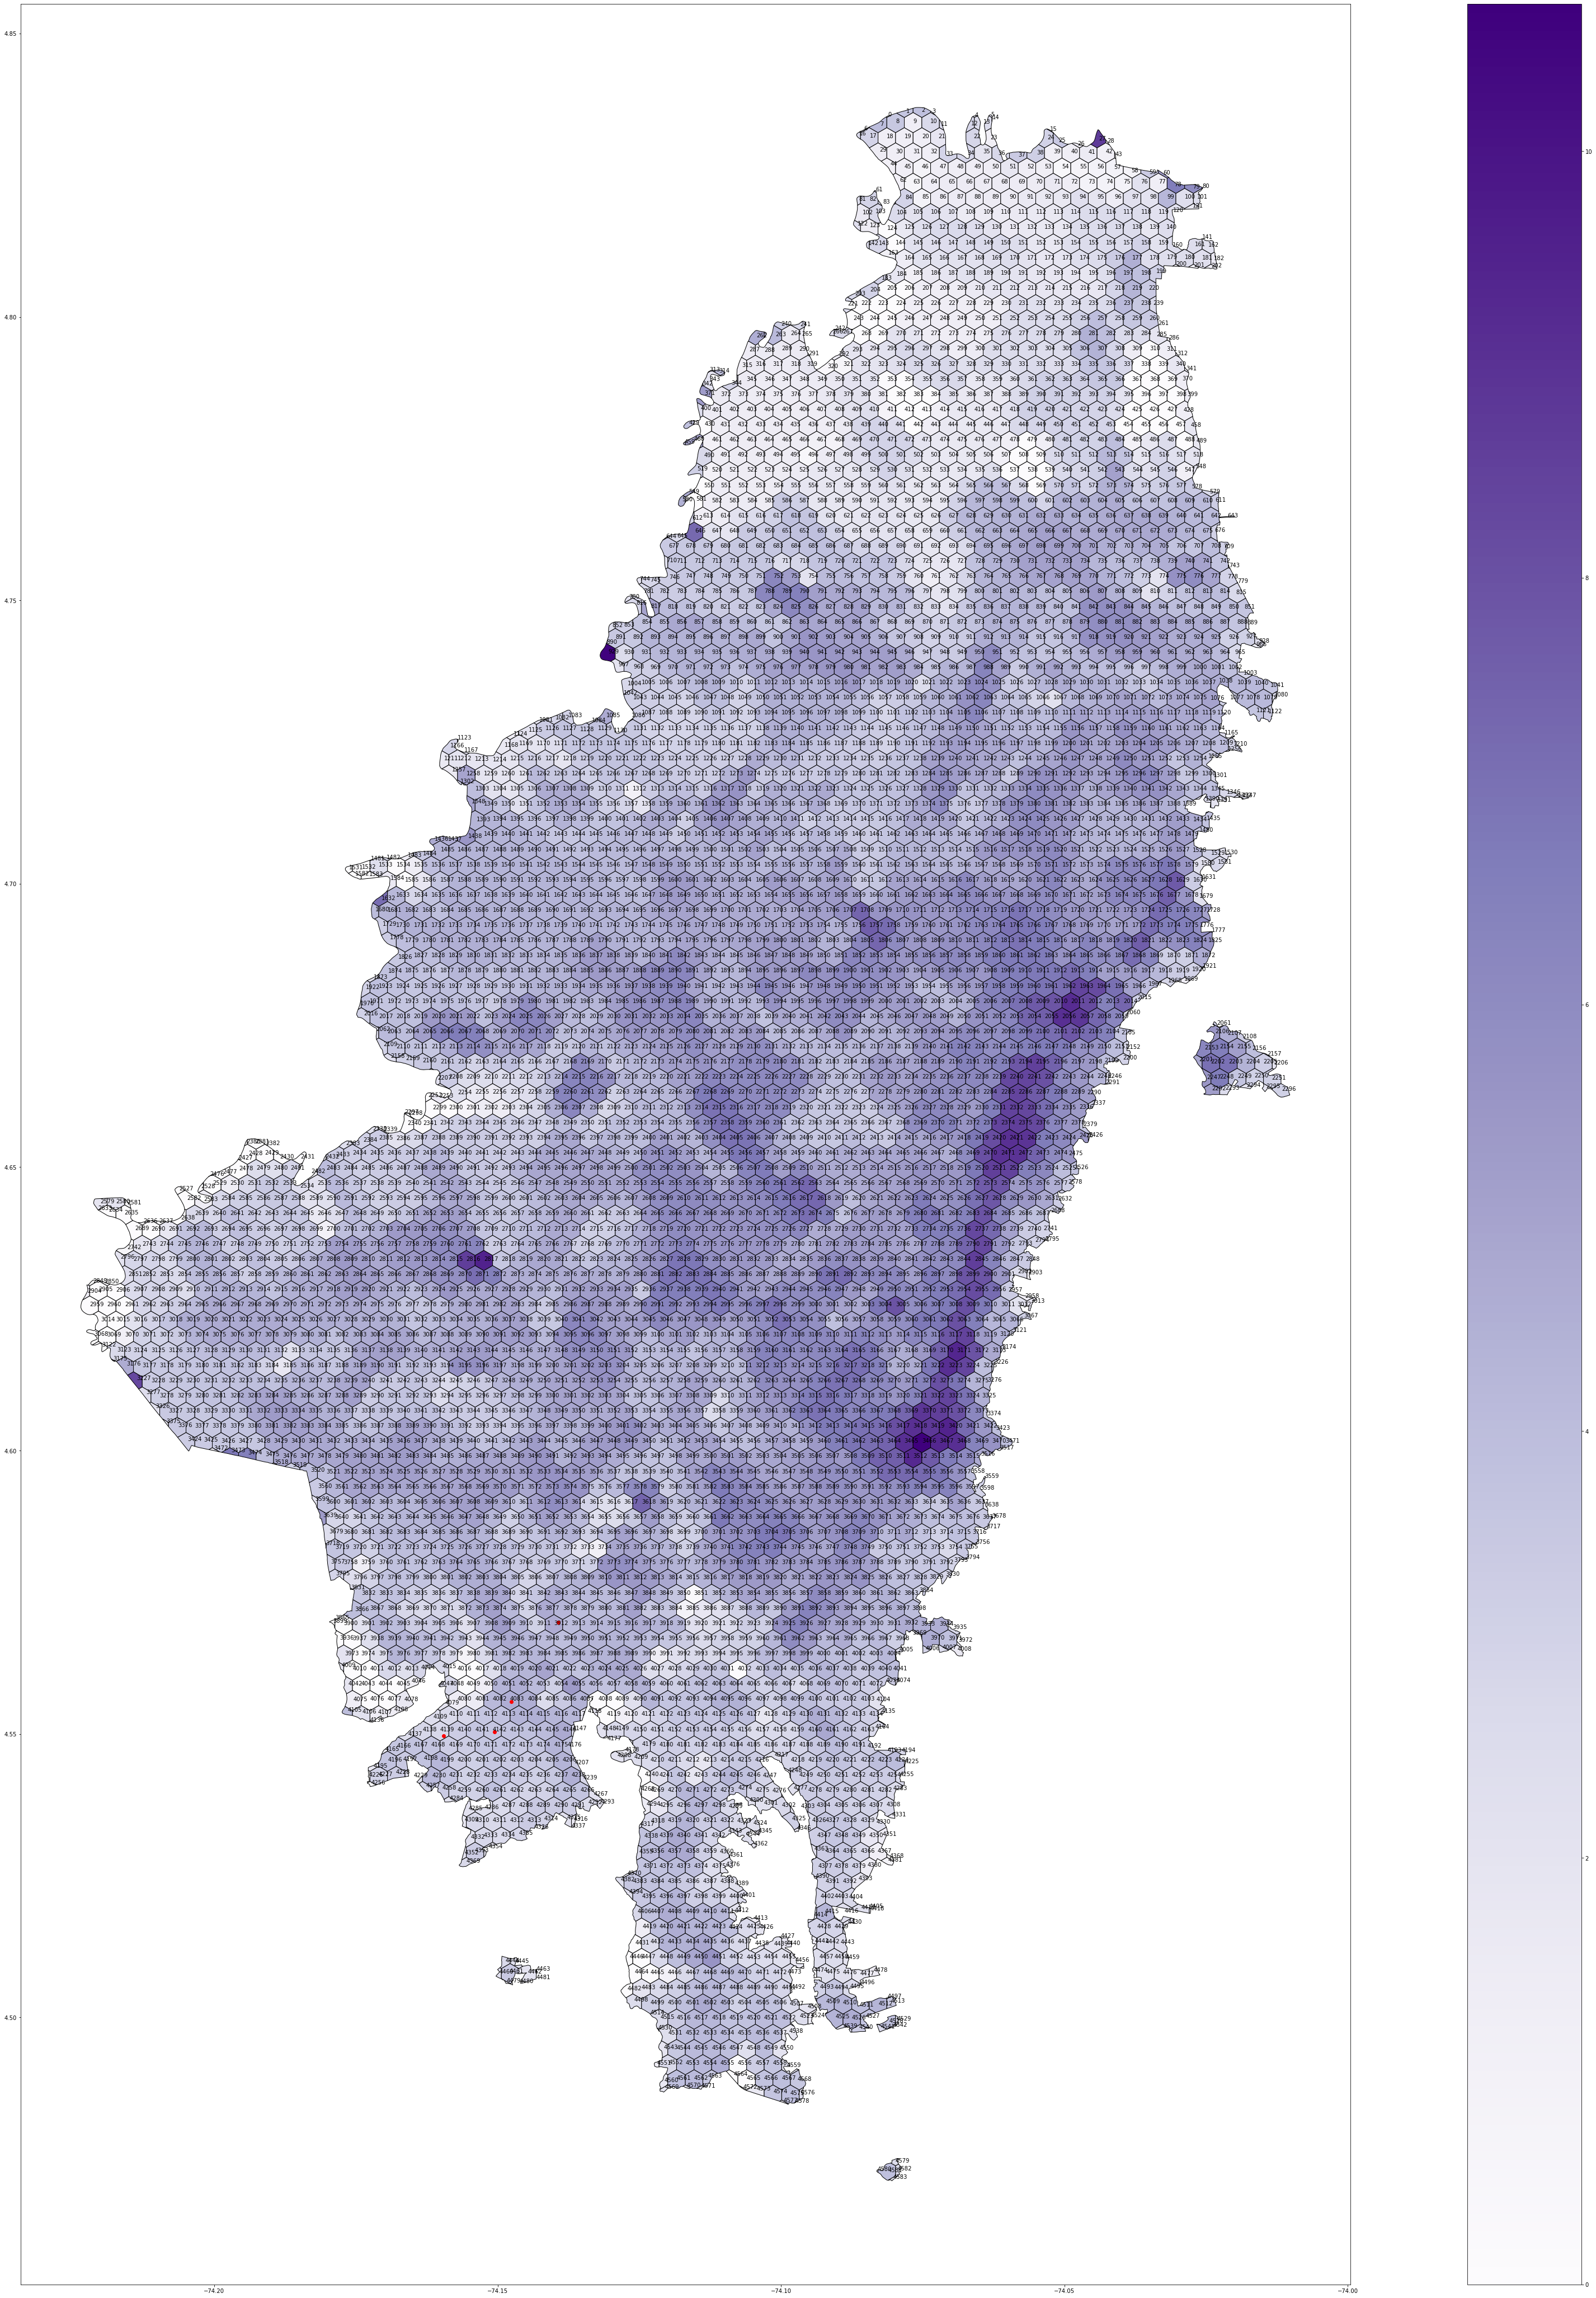

In [45]:
# When using double square root, notice how it becomes clear how jobs are concentrated at some points and not others
# Read hexagon file!!
bogota_hex_jobs = gpd.read_file('hex400_2020_07_30_bogota_hex_jobs.shp')

bogota_hex_jobs['sqrt_jobs'] = np.sqrt(np.sqrt(bogota_hex_jobs['jobs_count']))

ax = bogota_hex_jobs.plot(figsize=(75,75), edgecolor='black', facecolor='white', column='sqrt_jobs', legend=True, cmap='Purples')
#bogota_hex_centroid.crs = {'init' :'epsg:4326'}
#bogota_hex_centroid = bogota_hex_centroid.to_crs(epsg=3857)

# Plot all numbers corresponding to the cells
bogota_hex_centroid = bogota_hex_jobs.centroid
for long, lat, hexid in zip(bogota_hex_centroid.geometry.x, bogota_hex_centroid.geometry.y, bogota_hex_jobs['HEXID']):
    plt.text(long, lat, hexid, fontsize= 10)

# Gondola new 
gondola_stations = pd.read_csv('points_origins.csv')
gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
# gondola_stations.crs = {'init':'epsg:4326'}
# gondola_stations = gondola_stations.to_crs(epsg=3857)
gondola_stations.plot(ax=ax, color='r')

#ctx.add_basemap(ax)


In [25]:
i = str(3)+'dab'
i

'3dab'

Website on how to concatenate csv files:

https://stackoverflow.com/questions/44791212/concatenating-multiple-csv-files-into-a-single-csv-with-the-same-header-python#44791486
    

In [15]:
%%bash 
/Users/BrianHill/jython2.7.2/bin/jython -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar test_make_csv.py


00:08:59.708 INFO (OTPServer.java:39) Wiring up and configuring server.
00:08:59.748 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_no_gondola]
00:08:59.748 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
00:08:59.751 INFO (GraphService.java:176) Registering new router 'bogota_no_gondola'
00:08:59.752 INFO (InputStreamGraphSource.java:181) Loading graph...
00:09:00.177 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
00:09:00.178 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
00:09:00.178 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
00:09:11.032 INFO (Graph.java:731) Main graph read. |V|=268490 |E|=1328250
00:09:15.310 INFO (GraphIndex.java:127) Indexing graph...
00:09:17.680 INFO (GraphIndex.java:595) Clustering stops by geographic pro

hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
Traceback (most recent call last):
  File "test_make_csv.py", line 26, in <module>
    matrixCsv.save('z_origin_' + i + '.csv')
TypeError: cannot concatenate 'str' and 'int' objects


CalledProcessError: Command 'b'/Users/BrianHill/jython2.7.2/bin/jython -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar test_make_csv.py\n'' returned non-zero exit status 1.

Time to run with 1000 origins and destinations
Elapsed time was 8891.82 seconds

In [ ]:
# Make a plot of accessibility to check and see if it looks right


#### Gondola added

In [66]:
%%bash 
cat > travel_time_gondola_accessibility.py


# SOURCE: RAFAEL PRERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint

# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', 'bogota_gondola'])

# Start timing the code
import time
start_time = time.time()

# Get the default router
router = otp.getRouter('bogota_gondola')


# Create a default request for a given departure time
req = otp.createRequest()
req.setDateTime(2019, 9, 15, 10, 00, 00)  # set departure time 
req.setModes('WALK,BUS,RAIL,TRANSIT')             # define transport mode

# for more routing options, check: http://dev.opentripplanner.org/javadoc/0.19.0/org/opentripplanner/scripting/api/OtpsRoutingRequest.html


# Read Points of Destination - The file points.csv contains the columns GEOID, X and Y.
points = otp.loadCSVPopulation('job_count_by_block.csv', 'latitude', 'longitude')
dests = otp.loadCSVPopulation('job_count_by_block.csv', 'latitude', 'longitude')


# Create a CSV output
matrixCsv = otp.createCSVOutput()
matrixCsv.setHeader([ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ])

# Start Loop
for origin in points:
  print "Processing origin: ", origin
  req.setOrigin(origin)
  spt = router.plan(req)
  if spt is None: continue

  # Evaluate the SPT for all points
  result = spt.eval(dests)

  # Add a new row of result in the CSV output
  for r in result:
    matrixCsv.addRow([ origin.getStringData('OBJECTID'), r.getIndividual().getStringData('OBJECTID'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])

# Save the result
matrixCsv.save('travel_time_gondola_accessibility.csv')

# Stop timing the code
print("Elapsed time was %g seconds" % (time.time() - start_time))

In [ ]:
%%bash 
/Users/BrianHill/jython2.7.2/bin/jython -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar travel_time_gondola_accessibility.py


In [67]:
# We will load the travel_time_matrix (really just a long list) here 
travel_time_gondola_accessibility = pd.read_csv('travel_time_gondola_accessibility.csv')
travel_time_gondola_accessibility
travel_time_gondola_accessibility['travel_time_min'] = travel_time_gondola_accessibility['travel_time']/60
travel_time_gondola_accessibility = travel_time_gondola_accessibility.sort_values(['origin','destination'], ascending=True)
travel_time_gondola_accessibility

# Merge in the data on number of jobs accessible 
gondola_acc = pd.merge(travel_time_gondola_accessibility, job_count_by_block[['OBJECTID','jobs_count']], left_on='destination',right_on='OBJECTID')
gondola_acc = gondola_acc.sort_values(['origin','destination'],ascending=True)
gondola_acc

# Count how many jobs qualify for each origin point using groupby 
jobs_3600_gondola = gondola_acc[gondola_acc['travel_time'] < 3600].groupby('origin').sum()[['jobs_count']]
jobs_3600_gondola


# Merge in the coordinate data
jobs_3600_gondola = pd.merge(jobs_3600_gondola, job_count_by_block[['OBJECTID','latitude','longitude']], left_on='origin',right_on='OBJECTID')
jobs_3600_gondola


FileNotFoundError: [Errno 2] File travel_time_gondola_accessibility.csv does not exist: 'travel_time_gondola_accessibility.csv'

In [19]:
'''

%%bash 
cat > travel_time_gondola_accessibility_bolivar.py

# SUBSET TO LOOKING ONLY AT THE POINTS IN CIUDAD BOLIVAR AS ORIGINS 

router = 'bogota_gondola'
points_file = 'geo_job_count_origins.csv'
dest_file = 'job_count_by_block.csv'
output_file = 'travel_time_gondola_accessibility_bolivar.csv'


# SOURCE: RAFAEL PRERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint

# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', router])

# Start timing the code
import time
start_time = time.time()

# Get the default router
router = otp.getRouter(router)


# Create a default request for a given departure time
req = otp.createRequest()
req.setDateTime(2019, 4, 4, 9, 00, 00)  # set departure time 
req.setModes('WALK,BUS,RAIL,TRANSIT')             # define transport mode

# for more routing options, check: http://dev.opentripplanner.org/javadoc/0.19.0/org/opentripplanner/scripting/api/OtpsRoutingRequest.html


# Read Points of Destination - The file points.csv contains the columns GEOID, X and Y.
points = otp.loadCSVPopulation(points_file, 'latitude', 'longitude')
dests = otp.loadCSVPopulation(dest_file, 'latitude', 'longitude')


# Start Loop
for origin in points:
  print "Processing origin: ", origin
  req.setOrigin(origin)
  spt = router.plan(req)
  if spt is None: continue

  # Evaluate the SPT for all points
  result = spt.eval(dests)
  
  # Create a CSV output
  matrixCsv = otp.createCSVOutput()
  #matrixCsv.setHeader([ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ])

  # Add a new row of result in the CSV output
  for r in result:
    matrixCsv.addRow([ origin.getStringData('OBJECTID'), r.getIndividual().getStringData('OBJECTID'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])

  # Save the result
  csv_name = 'x_origin' + str(origin.getStringData('OBJECTID')) + '.csv'
  matrixCsv.save(csv_name)
  print(csv_name)
  print("Time since start was %g seconds" % (time.time() - start_time))


# Concatenate all of the csv files into one file 

import shutil
import glob


#import csv files from folder
path = r'/Users/BrianHill/otp'
allFiles = glob.glob(path + "/x_origin*.csv")
allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
with open(output_file, 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if True:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")


# Stop timing the code
print("Elapsed time was %g seconds" % (time.time() - start_time))

'''

In [16]:
'''
%%bash 
cat > travel_time_no_gondola_accessibility.py

# ATTEMPTED TO GRAB LATITUDE AND LONGITUDE INSTEAD OF GEOID, BUT NOT WORKING.  SO, WILL JUST USE GEOID
# CAN MERGE LATER AS DESIRED

# SOURCE: RAFAEL PRERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint

# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', 'bogota_no_gondola'])

# Start timing the code
import time
start_time = time.time()

# Get the default router
router = otp.getRouter('bogota_no_gondola')


# Create a default request for a given departure time
req = otp.createRequest()
req.setDateTime(2019, 4, 4, 9, 00, 00)  # set departure time 
req.setModes('WALK,BUS,RAIL,TRANSIT')             # define transport mode

# for more routing options, check: http://dev.opentripplanner.org/javadoc/0.19.0/org/opentripplanner/scripting/api/OtpsRoutingRequest.html


# Read Points of Destination - The file points.csv contains the columns GEOID, X and Y.
points = otp.loadCSVPopulation('points_origins.csv', 'longitude', 'latitude')
dests = otp.loadCSVPopulation('points_destinations.csv', 'longitude', 'latitude')


# Create a CSV output
matrixCsv = otp.createCSVOutput()
matrixCsv.setHeader([ 'origin','origin_long','origin_lat', 'destination_long','destination_lat', 'walk_distance', 'travel_time', 'boardings' ])

# Start Loop
for origin in points:
  print "Processing origin: ", origin
  req.setOrigin(origin)
  spt = router.plan(req)
  if spt is None: continue

  # Evaluate the SPT for all points
  result = spt.eval(dests)

  # Add a new row of result in the CSV output
  for r in result:
    matrixCsv.addRow([origin.getStringData('GEOID'),origin.getStringData('longitude'), origin.getStringData('latitude'), r.getIndividual().getStringData('longitude'), r.getIndividual().getStringData('latitude'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])

# Save the result
matrixCsv.save('travel_time_no_gondola_accessibility.csv')

# Stop timing the code
print("Elapsed time was %g seconds" % (time.time() - start_time))
'''